In [1]:
import os
import andes
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import scipy.stats as stat
import seaborn as sns

from andes.interop.pandapower import to_pandapower, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)
from math import ceil, floor

# virtual inertia scheduling class
from pdpower import make_link_table
from visopf import vis2_tds, loadnn

# function for main
from vistds import get_andes_case, get_load, disturbance

# TDS for VIS

## ini andes attribute

In [2]:
# ini andes attribute
case_path = '/VIS_opf/ieee39_vis_tds.xlsx'
ssa = get_andes_case(case_path)
ssa.TDS.config.no_tqdm = 1 # trun off tds progress fig to speed up sim

# ini load
ptotal = ssa.PQ.as_df()['p0'].sum()
gentotal = ssa.PV.as_df()['Sn'].sum() + ssa.Slack.as_df()['Sn'].sum()
gentotal /= ssa.config.mva
l_rate = ptotal/gentotal

print(f'Gen capacity is: {gentotal} p.u.\
        \nInitial load is: {ptotal.round(4)} p.u.\
        \ninitial load rate is {l_rate*100} %' )


Working directory: "/home/bshe/repos/andes/bshe/VIS_opf"
> Loaded config from file "/home/bshe/.andes/andes.rc"
> Loaded generated Python code in "/home/bshe/.andes/pycode".
Parsing input file "/home/bshe/repos/andes/bshe/VIS_opf/ieee39_vis_tds.xlsx"...
Input file parsed in 0.1309 seconds.
ACEc <1> added BusFreq <BusFreq_21> linked to bus <1>
System internal structure set up in 0.0492 seconds.


Gen capacity is: 109.389 p.u.        
Initial load is: 58.564 p.u.        
initial load rate is 53.537375787327804 %


array([0.04754391, 0.01445597, 0.03371435, 0.04081326, 0.05568563,
       0.05821878, 0.04284476, 0.03434477, 0.06373179, 0.07797526,
       0.05467633, 0.05058989])

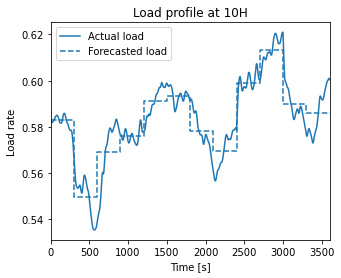

In [3]:
# load profile
data_path = '/VIS_opf/dsyn.csv'
d_syn, load_pic, dpe = get_load(data_path, load_time=10, l_rate=l_rate, scale=1.6)
dpe

# ini visopf instance

In [4]:
# get neural network data
nn_path = '/VIS_opf/NN_train'
nn, norm = loadnn(nn_path)

# ini visopf attribute
ssvis = vis2_tds(norm=norm, nn=nn, dpe=0.05, rocof_lim=0.0069 * (1.6/1.4), nadir_lim=0.01)

# set vsg gen
vsg_ieee39 = ['PV_1', 'PV_6', 'PV_8', 'PV_9']

# load from andes
ssvis.from_andes(ssa, vsg_ieee39, Sbase=1000)

# add gen cost:
# Note: if two gens have the same cost, optimization results of
#       pandapower and gurobipy may be different.
linearcost = [
                1,   # PV_1 vsg
                20, 
                20,
                20, 
                20, 
                1,   # PV_6 vsg
                20, 
                1,   # PV_8 vsg
                1,   # PV_9 vsg 
                20   # slack
            ]
quadraticcost = [
                0.001,   # PV_1 vsg
                0.014,
                0.020,
                0.019,
                0.021,
                0.001,   # PV_6 vsg
                0.020,
                0.001,   # PV_8 vsg
                0.001,   # PV_9 vsg
                0.026    # slack
            ]
for i in range(12):
    linearcost[i] /= 12
    quadraticcost[i] /= 12
    
# set up cost
ssvis.cost['c1'] = linearcost
ssvis.cost['c2'] = quadraticcost
ssvis.update_dict()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0083 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0098 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
Note: Control (dynamic) parameters are renormalized based on case Sbase rather then to andes base


# ini pandapower instance

In [5]:
# convert andes to a pandapower instance
ssp = to_pandapower(ssa)

# set up pandapower gen cost
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1
gen_cost[:, 4] = quadraticcost  # c2

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0070 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0123 seconds.
Power flow results are consistent. Conversion is successful.


True

### make link table between pandapower and andes

In [6]:
# --- link pandapower output to andes key ---
ssa_key = make_link_table(ssa)

# make index table to change pandapower and andes setting point
# pandapwoer uses dataframe index, i.g. 0, 1, 2 ....
# andes uses idx to call variable

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})

ssa_key2 = pd.merge(
                        left=ssa_key,
                        right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                        on='stg_idx', 
                        how='left'
                    )

# --- device idx ---
# use to set andes setting point
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()   
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist() 
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist() # static gen
ssa_rg_idx = ssa_key2.rg_idx.dropna().tolist()   # renewable gen: vsg

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)

ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

## TDS parameters

In [7]:
# --- TDS Constants ---
t_total = 3600  # total simulation time

# update interval
intv_ed = 300   # RTED
intv_agc = 4    # AGC
intv_pq = 1     # PQ load
intv_step = 100 # step change to smooth the setpoitns

# number of intervals
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- TDS vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

In [8]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = 1 * ssp.gen.max_p_mw # for AC

# store original generator data
ssp_gen0 = ssp.gen.copy()

# store visopf output
vis_res = {}

for time in range(t_total):  # t_total

    # ----------------------- RTED (VIS opf) interval -------------------------
    if time % intv_ed == 0:
        """
            RTED update with vis opf

            attributes:
            ----------
            - 01 get disturbance
            - 02 update visopf instance
            - 03 update pandapower instance
            - 04 update andes instance
        """
        # --- 01 get disturbance ---
        idx_ed = time // intv_ed
        load, dpe, dvsg_capacity = disturbance(d_syn, idx_ed, intv_ed)

        # --- 02 update visopf instance ---
        # load
        ssvis.load['p0'] = ssa_p0 * load # visopf load update
        # dpe
        ssvis.dpe = dpe
        # vsg gen capacity
        # TODO ... update vsg gen capacity of visopf

        ssvis.update_dict()

        # solve visopf
        sgres, vsg_res, sys_MD = ssvis.get_res()
        # save visopf result
        vis_res[f'sg_{idx_ed}'] = sgres.copy()
        vis_res[f'vsg_{idx_ed}'] = vsg_res.copy()
        vis_res[f'MDsys_{idx_ed}'] = sys_MD.copy()
        vis_res[f'dpe_{idx_ed}'] = dpe
        vis_res[f'cost_{idx_ed}'] = ssvis.mdl.getObjective().getValue()

        # --- 03 update pandapwoer instance ---
        # load
        ssp.load.scaling = load
        # pandapower gen
        ssp_gen = pd.merge(
                            left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=sgres.rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx',
                            how='left'
                        )

        # vsg power reserve limits
        # TODO: integrate delta vsg capacity change here
        ssp_gen['vsg_up'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['vsg_d'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva

        ssp.gen.max_p_mw = ssp_gen['vsg_up']
        ssp.gen.min_p_mw = ssp_gen['vsg_d']

        # run pandapower ACOPF, modify setpoints
        # store setpoints
        if time > 0:
            p0 = ssp_res['p'].values        # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis to normal limits
        # TODO: integrate delta vsg capacity change here
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # --- 04 update andes instance ---
        ssa.REGCV1.set(
                        src='M', 
                        idx= ssa.REGCV1.idx.v,
                        attr='v',
                        value= vsg_res['Mvsg']
                    )
        ssa.REGCV1.set(
                        src='D', 
                        idx= ssa.REGCV1.idx.v, 
                        attr='v',
                        value= vsg_res['Dvsg']
                    )

    # ---------------------- AGC interval -------------------------
    """
        AGC update

        attributes:
        ----------
        - 01 assign ACE signla to gen 
        - 02 smooth setpoints
    """
    ace_gain = 1

    if time % intv_agc == 0:
        idx_agc = time // intv_agc - idx_ed * n_agc
        # --- 01 allocate AGC ---

        # ACE_raw > 0: assign to expensive gen
        # ACE_raw < 0: assign to cheap gen
        # Note: allocate to synchronous generator governors
        # if ACE_raw > 0:
        #     agc_idx = ['TGOV1_10', 'TGOV1_2'] # TODO: change to expensive gen
        # else:
        #     agc_idx = ['TGOV1_4', 'TGOV1_5'] # TODO: change to cheap gen

        agc_idx = ['TGOV1_2','TGOV1_3','TGOV1_4','TGOV1_5','TGOV1_7', 'TGOV1_10']

        ssa.TurbineGov.set(
                            src='paux0',
                            idx= agc_idx,
                            attr='v',
                            value= ACE_raw/len(agc_idx) # allocate equally to each agc gen
                        )

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((time - idx_ed * intv_ed) // intv_agc + 1, n_step)

            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            # check ssp_res format for vsg setpoints
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(
                                src='pref0', 
                                idx=ssp_res.gov_idx[cond_gov].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_gov].values
                            )

            # update DG setpoints
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(
                        src='pref0', 
                        idx=ssp_res.dg_idx[cond_dg].tolist(),
                        attr='v', 
                        value=ssp_res.pref[cond_dg].values
                    )
                    
            # update vsg setpoints
            cond_rg = ssp_res.controllable & ssp_res.rg_idx.astype(bool)
            ssa.RenGen.set(
                                src='Pref', 
                                idx=ssp_res.rg_idx[cond_rg].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_rg].values
                            )

    # ----------------------- load change interval ----------------------
    """
        load change 

        attributes:
        ----------
        - 01 update load
        - 02 run TDS
    """
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if time == 0:
        # get idx from pandapower results
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()

        ssa.StaticGen.set(
                            src='p0',
                            idx=stg_opf_idx,
                            attr='v',
                            value=stg_opf_val
                        )
        ssa.StaticGen.set(
                            src='v0', 
                            idx=stg_opf_idx, 
                            attr='v', 
                            value=stg_opf_v
                        )

        # initial load point set as the dispatch point
        ssa.PQ.set(
                    src='p0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * load
                )
        ssa.PQ.set(
                    src='q0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * load
                )
        ssa.PFlow.run()
    else:
        ssa.PQ.set(
                    src='Ppf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * d_syn['sload'].iloc[time]
                )
        ssa.PQ.set(
                    src='Qpf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * d_syn['sload'].iloc[time]
                )

    # ----------------------- run TDS, cal ACE ----------------------
    # run TDS
    ssa.TDS.config.tf = time
    if time == 0:
        ssa.TDS.init()
        ACE_raw = 0 # delete when run TDS
    ssa.TDS.run()

    # update AGC using PI Controller
    ACE_integral += ssa.ACEc.ace.v.sum()
    ACE_raw = -( Kp * ssa.ACEc.ace.v.sum() + Ki * ACE_integral )

   # ----------------------- TDS error break ----------------------
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {time} s.")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11118 nonzeros
Model fingerprint: 0xfa824353
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 634.6178510
Presolve removed 781 rows and 490 columns
Presolve time: 0.02s
Presolved: 259 rows, 188 columns, 2933 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 103 continuous, 85 integer (85 binary)

Root relaxation: objective 6.300522e+02, 276 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 630.052
RoCof prediction: 0 ; RoCof limit: 0.00788571
Nadir prediction: -0 ; Nadir limit 0.01


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0167 seconds.
0: |F(x)| = 8.105442524
1: |F(x)| = 3.614890829
2: |F(x)| = 0.2069629733
3: |F(x)| = 0.001037077501
4: |F(x)| = 3.965659978e-08
Converged in 5 iterations in 0.0153 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000


Initialization for dynamics completed in 0.0747 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=0.00 sec completed

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x4104e0bb
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [5e-03, 2e+03]
Found heuristic solution: objective 588.9517849
Presolve removed 739 rows and 438 columns
Presolve time: 0.02s
Presolved: 301 rows, 240 columns, 3800 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 169 continuous, 71 integer (71 binary)

Root relaxation: objective 5.594046e+02, 380 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 559.405
RoCof prediction: -0.00788571 ; RoCof limit: 0.00788571
Nadir prediction: 0.00182685 ; Nadir limit 0.01


Simulation to t=300.00 sec completed in 0.1095 seconds.
Simulation to t=301.00 sec completed in 0.1101 seconds.
Simulation to t=302.00 sec completed in 0.1122 seconds.
Simulation to t=303.00 sec completed in 0.1075 seconds.
Simulation to t=304.00 sec completed in 0.1096 seconds.
Simulation to t=305.00 sec completed in 0.1045 seconds.
Simulation to t=306.00 sec completed in 0.1060 seconds.
Simulation to t=307.00 sec completed in 0.1165 seconds.
Simulation to t=308.00 sec completed in 0.1120 seconds.
Simulation to t=309.00 sec completed in 0.1025 seconds.
Simulation to t=310.00 sec completed in 0.1021 seconds.
Simulation to t=311.00 sec completed in 0.0947 seconds.
Simulation to t=312.00 sec completed in 0.1142 seconds.
Simulation to t=313.00 sec completed in 0.1050 seconds.
Simulation to t=314.00 sec completed in 0.1057 seconds.
Simulation to t=315.00 sec completed in 0.0924 seconds.
Simulation to t=316.00 sec completed in 0.1093 seconds.
Simulation to t=317.00 sec completed in 0.0945 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x2f365f4c
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [7e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 2e+03]
Found heuristic solution: objective 846.9930829
Presolve removed 701 rows and 418 columns
Presolve time: 0.02s
Presolved: 339 rows, 260 columns, 4267 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 173 continuous, 87 integer (87 binary)

Root relaxation: objective 6.027152e+02, 712 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 602.942
RoCof prediction: 0.00601306 ; RoCof limit: 0.00788571
Nadir prediction: -0.00110403 ; Nadir limit 0.01


Simulation to t=600.00 sec completed in 0.0824 seconds.
Simulation to t=601.00 sec completed in 0.0851 seconds.
Simulation to t=602.00 sec completed in 0.0778 seconds.
Simulation to t=603.00 sec completed in 0.0865 seconds.
Simulation to t=604.00 sec completed in 0.0802 seconds.
Simulation to t=605.00 sec completed in 0.0791 seconds.
Simulation to t=606.00 sec completed in 0.0837 seconds.
Simulation to t=607.00 sec completed in 0.0781 seconds.
Simulation to t=608.00 sec completed in 0.0807 seconds.
Simulation to t=609.00 sec completed in 0.0775 seconds.
Simulation to t=610.00 sec completed in 0.0840 seconds.
Simulation to t=611.00 sec completed in 0.0743 seconds.
Simulation to t=612.00 sec completed in 0.0787 seconds.
Simulation to t=613.00 sec completed in 0.0800 seconds.
Simulation to t=614.00 sec completed in 0.0825 seconds.
Simulation to t=615.00 sec completed in 0.1091 seconds.
Simulation to t=616.00 sec completed in 0.0840 seconds.
Simulation to t=617.00 sec completed in 0.0815 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xd2b21d07
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [3e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-03, 2e+03]
Found heuristic solution: objective 800.1919774
Presolve removed 701 rows and 418 columns
Presolve time: 0.02s
Presolved: 339 rows, 260 columns, 4267 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 173 continuous, 87 integer (87 binary)

Root relaxation: objective 6.178771e+02, 714 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS
Simulation to t=900.00 sec completed in 0.0920 seconds.
Simulation to t=901.00 sec completed in 0.0890 seconds.
Simulation to t=902.00 sec completed in 0.0894 seconds.
Simulation to t=903.00 sec completed in 0.0922 seconds.
Simulation to t=904.00 sec completed in 0.0957 seconds.
Simulation to t=905.00 sec completed in 0.0870 seconds.
Simulation to t=906.00 sec completed in 0.1155 seconds.
Simulation to t=907.00 sec completed in 0.0867 seconds.
Simulation to t=908.00 sec completed in 0.0882 seconds.
Simulation to t=909.00 sec completed in 0.0933 seconds.
Simulation to t=910.00 sec completed in 0.0915 seconds.
Simulation to t=911.00 sec completed in 0.0841 seconds.
Simulation to t=912.00 sec completed in 0.0968 seconds.
Simulation to t=913.00 sec completed in 0.0936 seconds.
Simulation to t=914.00 sec completed in 0.0910 seconds.
Simulation to t=915.00 sec completed in 0.1136 seconds.
Simulation to t=916.00

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x4fe34c18
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [6e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 849.4299771
Presolve removed 709 rows and 425 columns
Presolve time: 0.02s
Presolved: 331 rows, 253 columns, 4178 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.510414e+02, 696 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 651.216
RoCof prediction: 0.00464361 ; RoCof limit: 0.00788571
Nadir prediction: -0.000829448 ; Nadir limit 0.01


Simulation to t=1200.00 sec completed in 0.0883 seconds.
Simulation to t=1201.00 sec completed in 0.0928 seconds.
Simulation to t=1202.00 sec completed in 0.1334 seconds.
Simulation to t=1203.00 sec completed in 0.1178 seconds.
Simulation to t=1204.00 sec completed in 0.1387 seconds.
Simulation to t=1205.00 sec completed in 0.0893 seconds.
Simulation to t=1206.00 sec completed in 0.0930 seconds.
Simulation to t=1207.00 sec completed in 0.0856 seconds.
Simulation to t=1208.00 sec completed in 0.1194 seconds.
Simulation to t=1209.00 sec completed in 0.0846 seconds.
Simulation to t=1210.00 sec completed in 0.1258 seconds.
Simulation to t=1211.00 sec completed in 0.0851 seconds.
Simulation to t=1212.00 sec completed in 0.0869 seconds.
Simulation to t=1213.00 sec completed in 0.0901 seconds.
Simulation to t=1214.00 sec completed in 0.0805 seconds.
Simulation to t=1215.00 sec completed in 0.0855 seconds.
Simulation to t=1216.00 sec completed in 0.1451 seconds.
Simulation to t=1217.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xe00ed56f
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 2e+03]
Presolve removed 709 rows and 425 columns
Presolve time: 0.02s
Presolved: 331 rows, 253 columns, 4168 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.561326e+02, 712 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 656.162
RoCof prediction: 0.000790928 ; RoCof limit: 0.00788571
Nadir prediction: -0.000140912 ; Nadir limit 0.01


Simulation to t=1500.00 sec completed in 0.0960 seconds.
Simulation to t=1501.00 sec completed in 0.0827 seconds.
Simulation to t=1502.00 sec completed in 0.0852 seconds.
Simulation to t=1503.00 sec completed in 0.0895 seconds.
Simulation to t=1504.00 sec completed in 0.0834 seconds.
Simulation to t=1505.00 sec completed in 0.0934 seconds.
Simulation to t=1506.00 sec completed in 0.0906 seconds.
Simulation to t=1507.00 sec completed in 0.0864 seconds.
Simulation to t=1508.00 sec completed in 0.0863 seconds.
Simulation to t=1509.00 sec completed in 0.1385 seconds.
Simulation to t=1510.00 sec completed in 0.0967 seconds.
Simulation to t=1511.00 sec completed in 0.0885 seconds.
Simulation to t=1512.00 sec completed in 0.0837 seconds.
Simulation to t=1513.00 sec completed in 0.0987 seconds.
Simulation to t=1514.00 sec completed in 0.0915 seconds.
Simulation to t=1515.00 sec completed in 0.0879 seconds.
Simulation to t=1516.00 sec completed in 0.1283 seconds.
Simulation to t=1517.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x20fa1d22
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [6e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 642.0871531
Presolve removed 703 rows and 420 columns
Presolve time: 0.03s
Presolved: 337 rows, 258 columns, 4252 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 172 continuous, 86 integer (86 binary)

Root relaxation: objective 6.220677e+02, 414 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 622.068
RoCof prediction: -0.00458772 ; RoCof limit: 0.00788571
Nadir prediction: 0.000867489 ; Nadir limit 0.01


Simulation to t=1800.00 sec completed in 0.0873 seconds.
Simulation to t=1801.00 sec completed in 0.1148 seconds.
Simulation to t=1802.00 sec completed in 0.0856 seconds.
Simulation to t=1803.00 sec completed in 0.0836 seconds.
Simulation to t=1804.00 sec completed in 0.0921 seconds.
Simulation to t=1805.00 sec completed in 0.0904 seconds.
Simulation to t=1806.00 sec completed in 0.0831 seconds.
Simulation to t=1807.00 sec completed in 0.0887 seconds.
Simulation to t=1808.00 sec completed in 0.0901 seconds.
Simulation to t=1809.00 sec completed in 0.0949 seconds.
Simulation to t=1810.00 sec completed in 0.0875 seconds.
Simulation to t=1811.00 sec completed in 0.0932 seconds.
Simulation to t=1812.00 sec completed in 0.0820 seconds.
Simulation to t=1813.00 sec completed in 0.0862 seconds.
Simulation to t=1814.00 sec completed in 0.0870 seconds.
Simulation to t=1815.00 sec completed in 0.0818 seconds.
Simulation to t=1816.00 sec completed in 0.0837 seconds.
Simulation to t=1817.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x80b9d34a
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [3e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [5e-03, 2e+03]
Found heuristic solution: objective 623.4299636
Presolve removed 701 rows and 418 columns
Presolve time: 0.02s
Presolved: 339 rows, 260 columns, 4271 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 173 continuous, 87 integer (87 binary)

Root relaxation: objective 6.032990e+02, 408 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 603.299
RoCof prediction: -0.00253646 ; RoCof limit: 0.00788571
Nadir prediction: 0.000484659 ; Nadir limit 0.01


Simulation to t=2100.00 sec completed in 0.1425 seconds.
Simulation to t=2101.00 sec completed in 0.1040 seconds.
Simulation to t=2102.00 sec completed in 0.0975 seconds.
Simulation to t=2103.00 sec completed in 0.0950 seconds.
Simulation to t=2104.00 sec completed in 0.1062 seconds.
Simulation to t=2105.00 sec completed in 0.0886 seconds.
Simulation to t=2106.00 sec completed in 0.0863 seconds.
Simulation to t=2107.00 sec completed in 0.0919 seconds.
Simulation to t=2108.00 sec completed in 0.1008 seconds.
Simulation to t=2109.00 sec completed in 0.0943 seconds.
Simulation to t=2110.00 sec completed in 0.1480 seconds.
Simulation to t=2111.00 sec completed in 0.1021 seconds.
Simulation to t=2112.00 sec completed in 0.1089 seconds.
Simulation to t=2113.00 sec completed in 0.0982 seconds.
Simulation to t=2114.00 sec completed in 0.0978 seconds.
Simulation to t=2115.00 sec completed in 0.0956 seconds.
Simulation to t=2116.00 sec completed in 0.1071 seconds.
Simulation to t=2117.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x1739a534
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Found heuristic solution: objective 717.2700847
Presolve removed 712 rows and 434 columns
Presolve time: 0.03s
Presolved: 328 rows, 244 columns, 4095 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 164 continuous, 80 integer (80 binary)

Root relaxation: objective 6.701460e+02, 690 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 670.506
RoCof prediction: 0.00788571 ; RoCof limit: 0.00788571
Nadir prediction: -0.00153714 ; Nadir limit 0.01


Simulation to t=2400.00 sec completed in 0.1124 seconds.
Simulation to t=2401.00 sec completed in 0.1150 seconds.
Simulation to t=2402.00 sec completed in 0.1241 seconds.
Simulation to t=2403.00 sec completed in 0.1748 seconds.
Simulation to t=2404.00 sec completed in 0.1268 seconds.
Simulation to t=2405.00 sec completed in 0.1275 seconds.
Simulation to t=2406.00 sec completed in 0.1111 seconds.
Simulation to t=2407.00 sec completed in 0.1188 seconds.
Simulation to t=2408.00 sec completed in 0.1217 seconds.
Simulation to t=2409.00 sec completed in 0.1812 seconds.
Simulation to t=2410.00 sec completed in 0.1329 seconds.
Simulation to t=2411.00 sec completed in 0.1235 seconds.
Simulation to t=2412.00 sec completed in 0.1235 seconds.
Simulation to t=2413.00 sec completed in 0.1230 seconds.
Simulation to t=2414.00 sec completed in 0.1271 seconds.
Simulation to t=2415.00 sec completed in 0.1425 seconds.
Simulation to t=2416.00 sec completed in 0.0940 seconds.
Simulation to t=2417.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x05d26125
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [6e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 851.9048335
Presolve removed 709 rows and 425 columns
Presolve time: 0.03s
Presolved: 331 rows, 253 columns, 4178 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 7.002674e+02, 698 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 700.457
RoCof prediction: 0.00444725 ; RoCof limit: 0.00788571
Nadir prediction: -0.000673505 ; Nadir limit 0.01


Simulation to t=2700.00 sec completed in 0.0830 seconds.
Simulation to t=2701.00 sec completed in 0.0886 seconds.
Simulation to t=2702.00 sec completed in 0.0872 seconds.
Simulation to t=2703.00 sec completed in 0.0917 seconds.
Simulation to t=2704.00 sec completed in 0.0857 seconds.
Simulation to t=2705.00 sec completed in 0.0849 seconds.
Simulation to t=2706.00 sec completed in 0.0932 seconds.
Simulation to t=2707.00 sec completed in 0.0890 seconds.
Simulation to t=2708.00 sec completed in 0.0914 seconds.
Simulation to t=2709.00 sec completed in 0.1032 seconds.
Simulation to t=2710.00 sec completed in 0.1007 seconds.
Simulation to t=2711.00 sec completed in 0.1006 seconds.
Simulation to t=2712.00 sec completed in 0.0960 seconds.
Simulation to t=2713.00 sec completed in 0.0878 seconds.
Simulation to t=2714.00 sec completed in 0.0908 seconds.
Simulation to t=2715.00 sec completed in 0.0928 seconds.
Simulation to t=2716.00 sec completed in 0.1113 seconds.
Simulation to t=2717.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x735ff63d
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [9e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Found heuristic solution: objective 668.0396857
Presolve removed 709 rows and 425 columns
Presolve time: 0.02s
Presolved: 331 rows, 253 columns, 4179 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.482021e+02, 404 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 648.202
RoCof prediction: -0.00695257 ; RoCof limit: 0.00788571
Nadir prediction: 0.00129542 ; Nadir limit 0.01


Simulation to t=3000.00 sec completed in 0.0950 seconds.
Simulation to t=3001.00 sec completed in 0.0926 seconds.
Simulation to t=3002.00 sec completed in 0.1110 seconds.
Simulation to t=3003.00 sec completed in 0.1142 seconds.
Simulation to t=3004.00 sec completed in 0.1398 seconds.
Simulation to t=3005.00 sec completed in 0.1300 seconds.
Simulation to t=3006.00 sec completed in 0.1323 seconds.
Simulation to t=3007.00 sec completed in 0.1366 seconds.
Simulation to t=3008.00 sec completed in 0.1411 seconds.
Simulation to t=3009.00 sec completed in 0.1440 seconds.
Simulation to t=3010.00 sec completed in 0.1469 seconds.
Simulation to t=3011.00 sec completed in 0.0906 seconds.
Simulation to t=3012.00 sec completed in 0.1892 seconds.
Simulation to t=3013.00 sec completed in 0.0957 seconds.
Simulation to t=3014.00 sec completed in 0.1100 seconds.
Simulation to t=3015.00 sec completed in 0.1048 seconds.
Simulation to t=3016.00 sec completed in 0.1156 seconds.
Simulation to t=3017.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x3c3a2c19
Model has 10 quadratic objective terms
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [2e-08, 1e+02]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 5e-02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 2e+03]
Presolve removed 709 rows and 425 columns
Presolve time: 0.02s
Presolved: 331 rows, 253 columns, 4176 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 170 continuous, 83 integer (83 binary)

Root relaxation: objective 6.391744e+02, 404 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS
Simulation to t=3300.00 sec completed in 0.0997 seconds.
Simulation to t=3301.00 sec completed in 0.0978 seconds.
Simulation to t=3302.00 sec completed in 0.1306 seconds.
Simulation to t=3303.00 sec completed in 0.1019 seconds.
Simulation to t=3304.00 sec completed in 0.0941 seconds.
Simulation to t=3305.00 sec completed in 0.0867 seconds.
Simulation to t=3306.00 sec completed in 0.0985 seconds.
Simulation to t=3307.00 sec completed in 0.0914 seconds.
Simulation to t=3308.00 sec completed in 0.0859 seconds.
Simulation to t=3309.00 sec completed in 0.1639 seconds.
Simulation to t=3310.00 sec completed in 0.0985 seconds.
Simulation to t=3311.00 sec completed in 0.0852 seconds.
Simulation to t=3312.00 sec completed in 0.0985 seconds.
Simulation to t=3313.00 sec completed in 0.1032 seconds.
Simulation to t=3314.00 sec completed in 0.1006 seconds.
Simulation to t=3315.00 sec completed in 0.0940 seconds.
Simula

# Plot results

## plot load profile

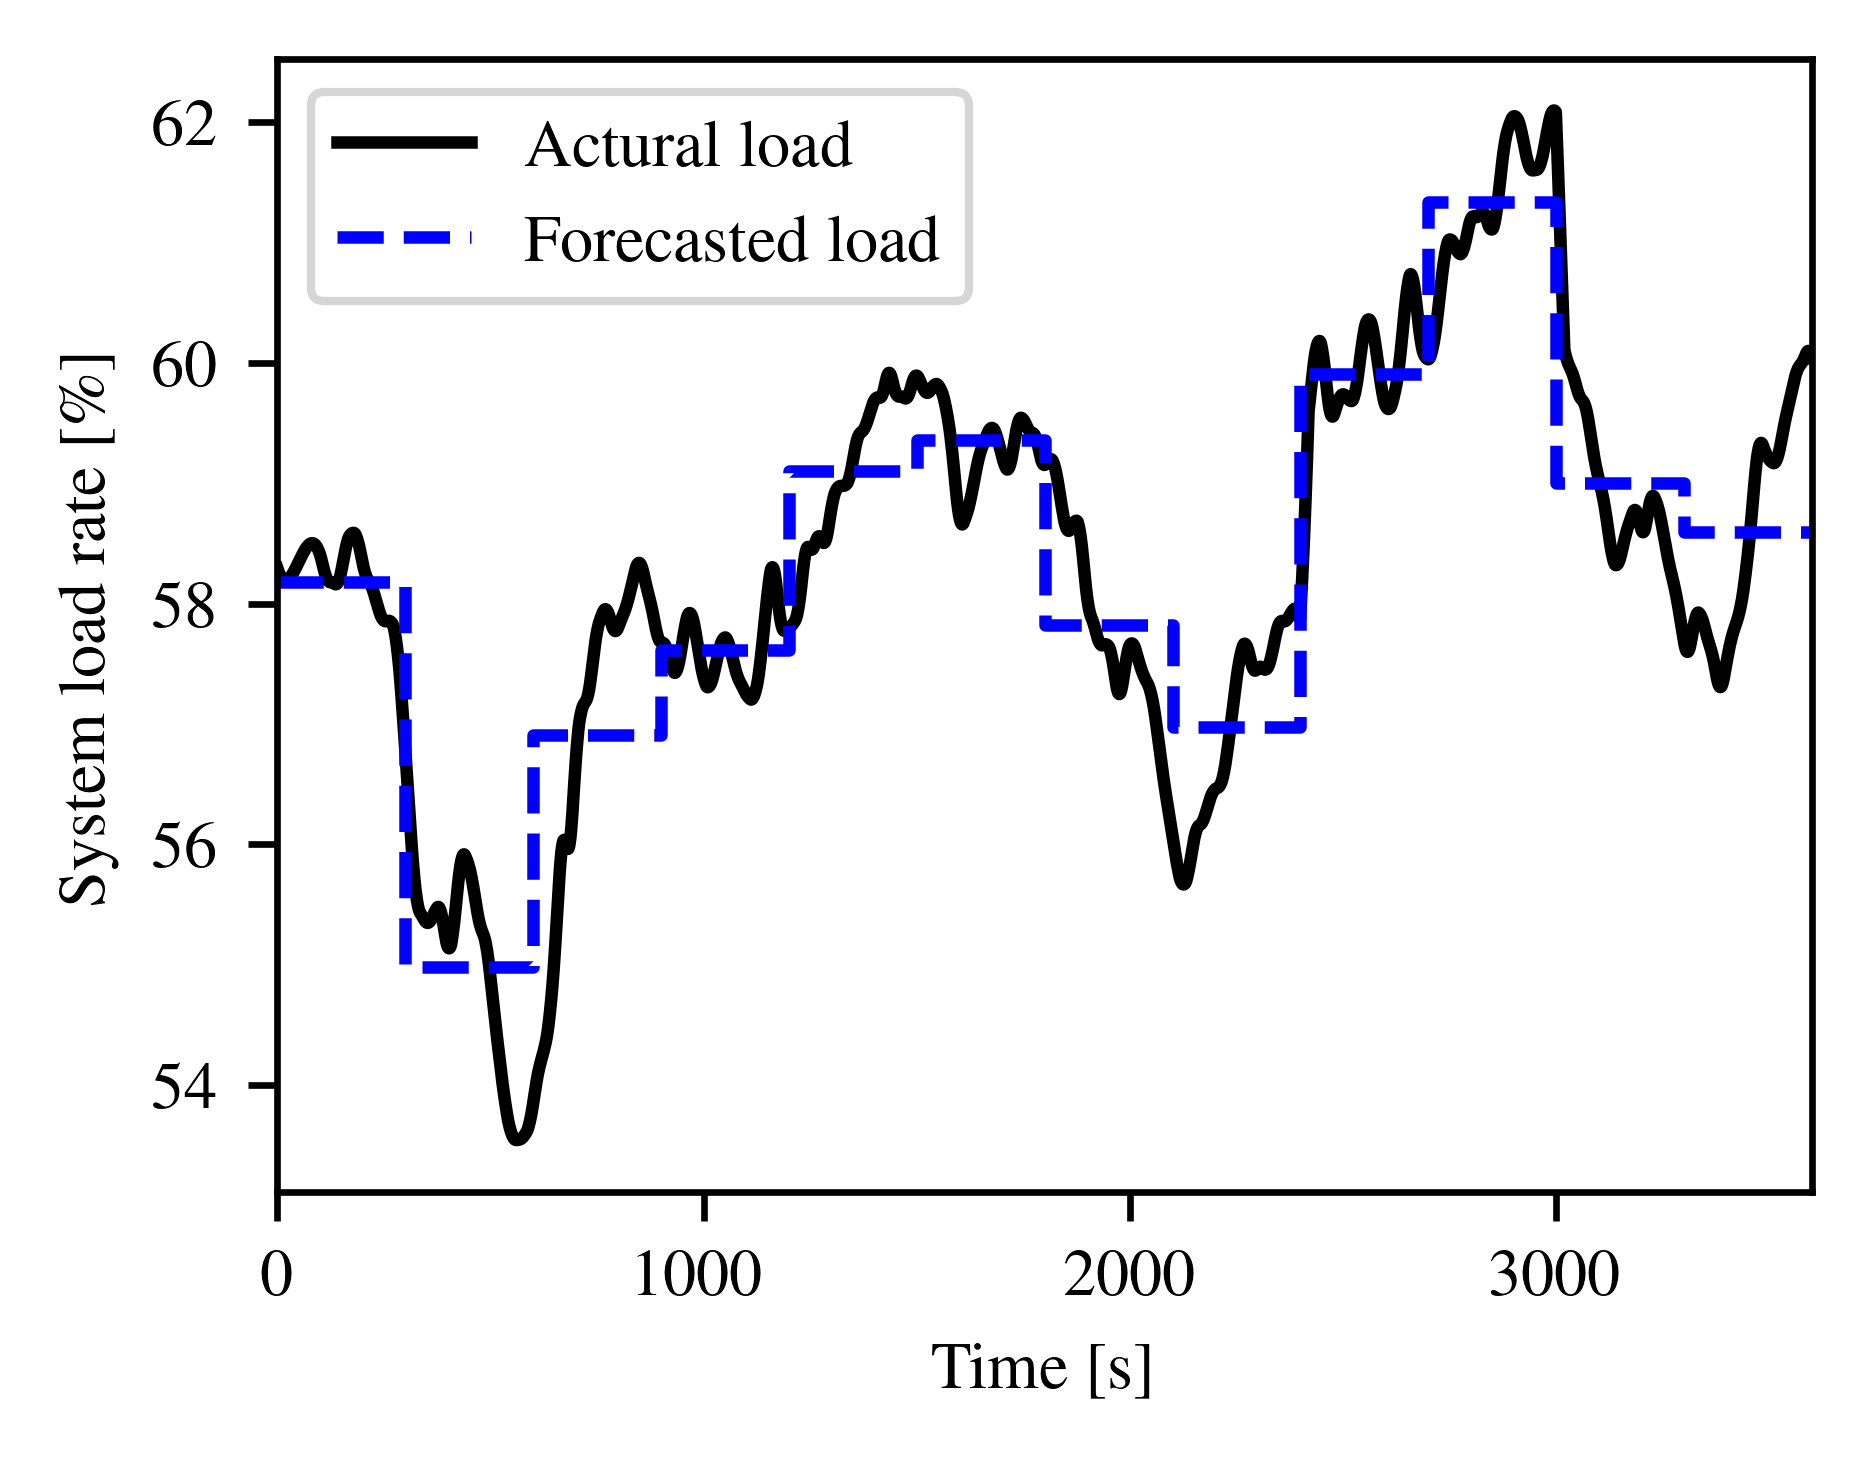

In [9]:
# plot load profile soterd in 'd_syn'
plt.style.use('ieee')
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots()
# tds load profile

ax.plot(
            d_syn['time'], 
            np.array(d_syn['sload']) * l_rate * 100,
            label = 'Actural load',
            linestyle='-'
        )

d_exp = d_syn.groupby(d_syn.index // 300).mean()
d_exp['time'] = range(0, 3600, 300)
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])

ax.step(
            range(0,3900,300), 
            np.array(ystep) * l_rate * 100,
            label = 'Forecasted load',
            color ='blue',
            linestyle='--'
        )

ax.set_xlabel('Time [s]')
ax.set_ylabel(r'System load rate [\%]')
ax.set_xlim(0, 3600, 600)
ax.legend()

## plot scheduling results

### plot cost
data
vis_res: dict
```
    vis_res[f'sg_{idx_ed}'] → dataframe
    vis_res[f'vsg_{idx_ed}'] → dataframe
    vis_res[f'MDsys_{idx_ed}'] → dict
    vis_res[f'dpe_{idx_ed}'] → int
```

sg dataframe: [gen Sn  pg  pru prd ] \
vsg dataframe: [gen  Mvsg  Dvsg pg_vsg  pru_vsg  prd_vsg  pmax_vsg  pmin_vsg] \
MDsys: {'Msys': ..., 'Dsys': ..., 'Rsys': ..., 'Fsys': ...}

In [10]:
# -----------------------Total Cost data ----------------------

base_cost = np.array(linearcost)
rs_cost = np.array([
                    20.11,
                    0,
                    0,
                    0,
                    0,
                    20.16,
                    0,
                    20.15,
                    20.16,
                    0
                ]) # vsg reserve cost
rs_cost /= 12

total_cost = []
delta_Pe = []
gen_cost = []
vsg_reserve_cost = []

for idx in range(12):
    # delta Pe
    delta_Pe.append(vis_res[f'dpe_{idx}'])
    # gen cost
    gen_cost.append(vis_res[f'cost_{idx}'])
    # vsg reserve cost
    up_reserve = vis_res[f'sg_{idx}']['pru'].values
    dn_reserve = vis_res[f'sg_{idx}']['prd'].values
    reserve = up_reserve + dn_reserve
    cost_reserve = np.inner(reserve, rs_cost)
    vsg_reserve_cost.append(cost_reserve)
    # total cost
    total_cost.append(gen_cost[idx] + cost_reserve)

# update the first interval
delta_Pe[0] = delta_Pe[1]/2
total_cost[0] += vsg_reserve_cost[0]
vsg_reserve_cost[0] = vsg_reserve_cost[1]/2

In [11]:
# -------------------- cost data for each gen ----------------------
# gen data and reserve data
sg_gen = pd.DataFrame()
pru_gen = pd.DataFrame()
prd_gen = pd.DataFrame()

for idx in range(12):
    sg_gen[f'{idx}'] = vis_res[f'sg_{idx}']['pg']
    pru_gen[f'{idx}'] = vis_res[f'sg_{idx}']['pru']
    prd_gen[f'{idx}'] = vis_res[f'sg_{idx}']['prd']

# gen cost and reserve cost
# TODO

complete_gen_cost = sg_gen.values.T * linearcost 

complete_rs_cost = pru_gen.values.T * rs_cost + prd_gen.values.T * rs_cost

complete_cost = complete_gen_cost + complete_rs_cost

temp = complete_cost.T
complete_cost.shape # (12, 10): (VIS interval, gen number)

(12, 10)

In [12]:
pru_gen.values.sum(axis=1) + prd_gen.values.sum(axis=1)

array([0.12522247, 0.        , 0.        , 0.        , 0.        ,
       0.17392258, 0.        , 0.11032977, 0.19264378, 0.        ])

In [13]:
from matplotlib.pyplot import MultipleLocator

Text(12.5, 10.6, 'Cost [$\\times {10}^4$ \\$]')

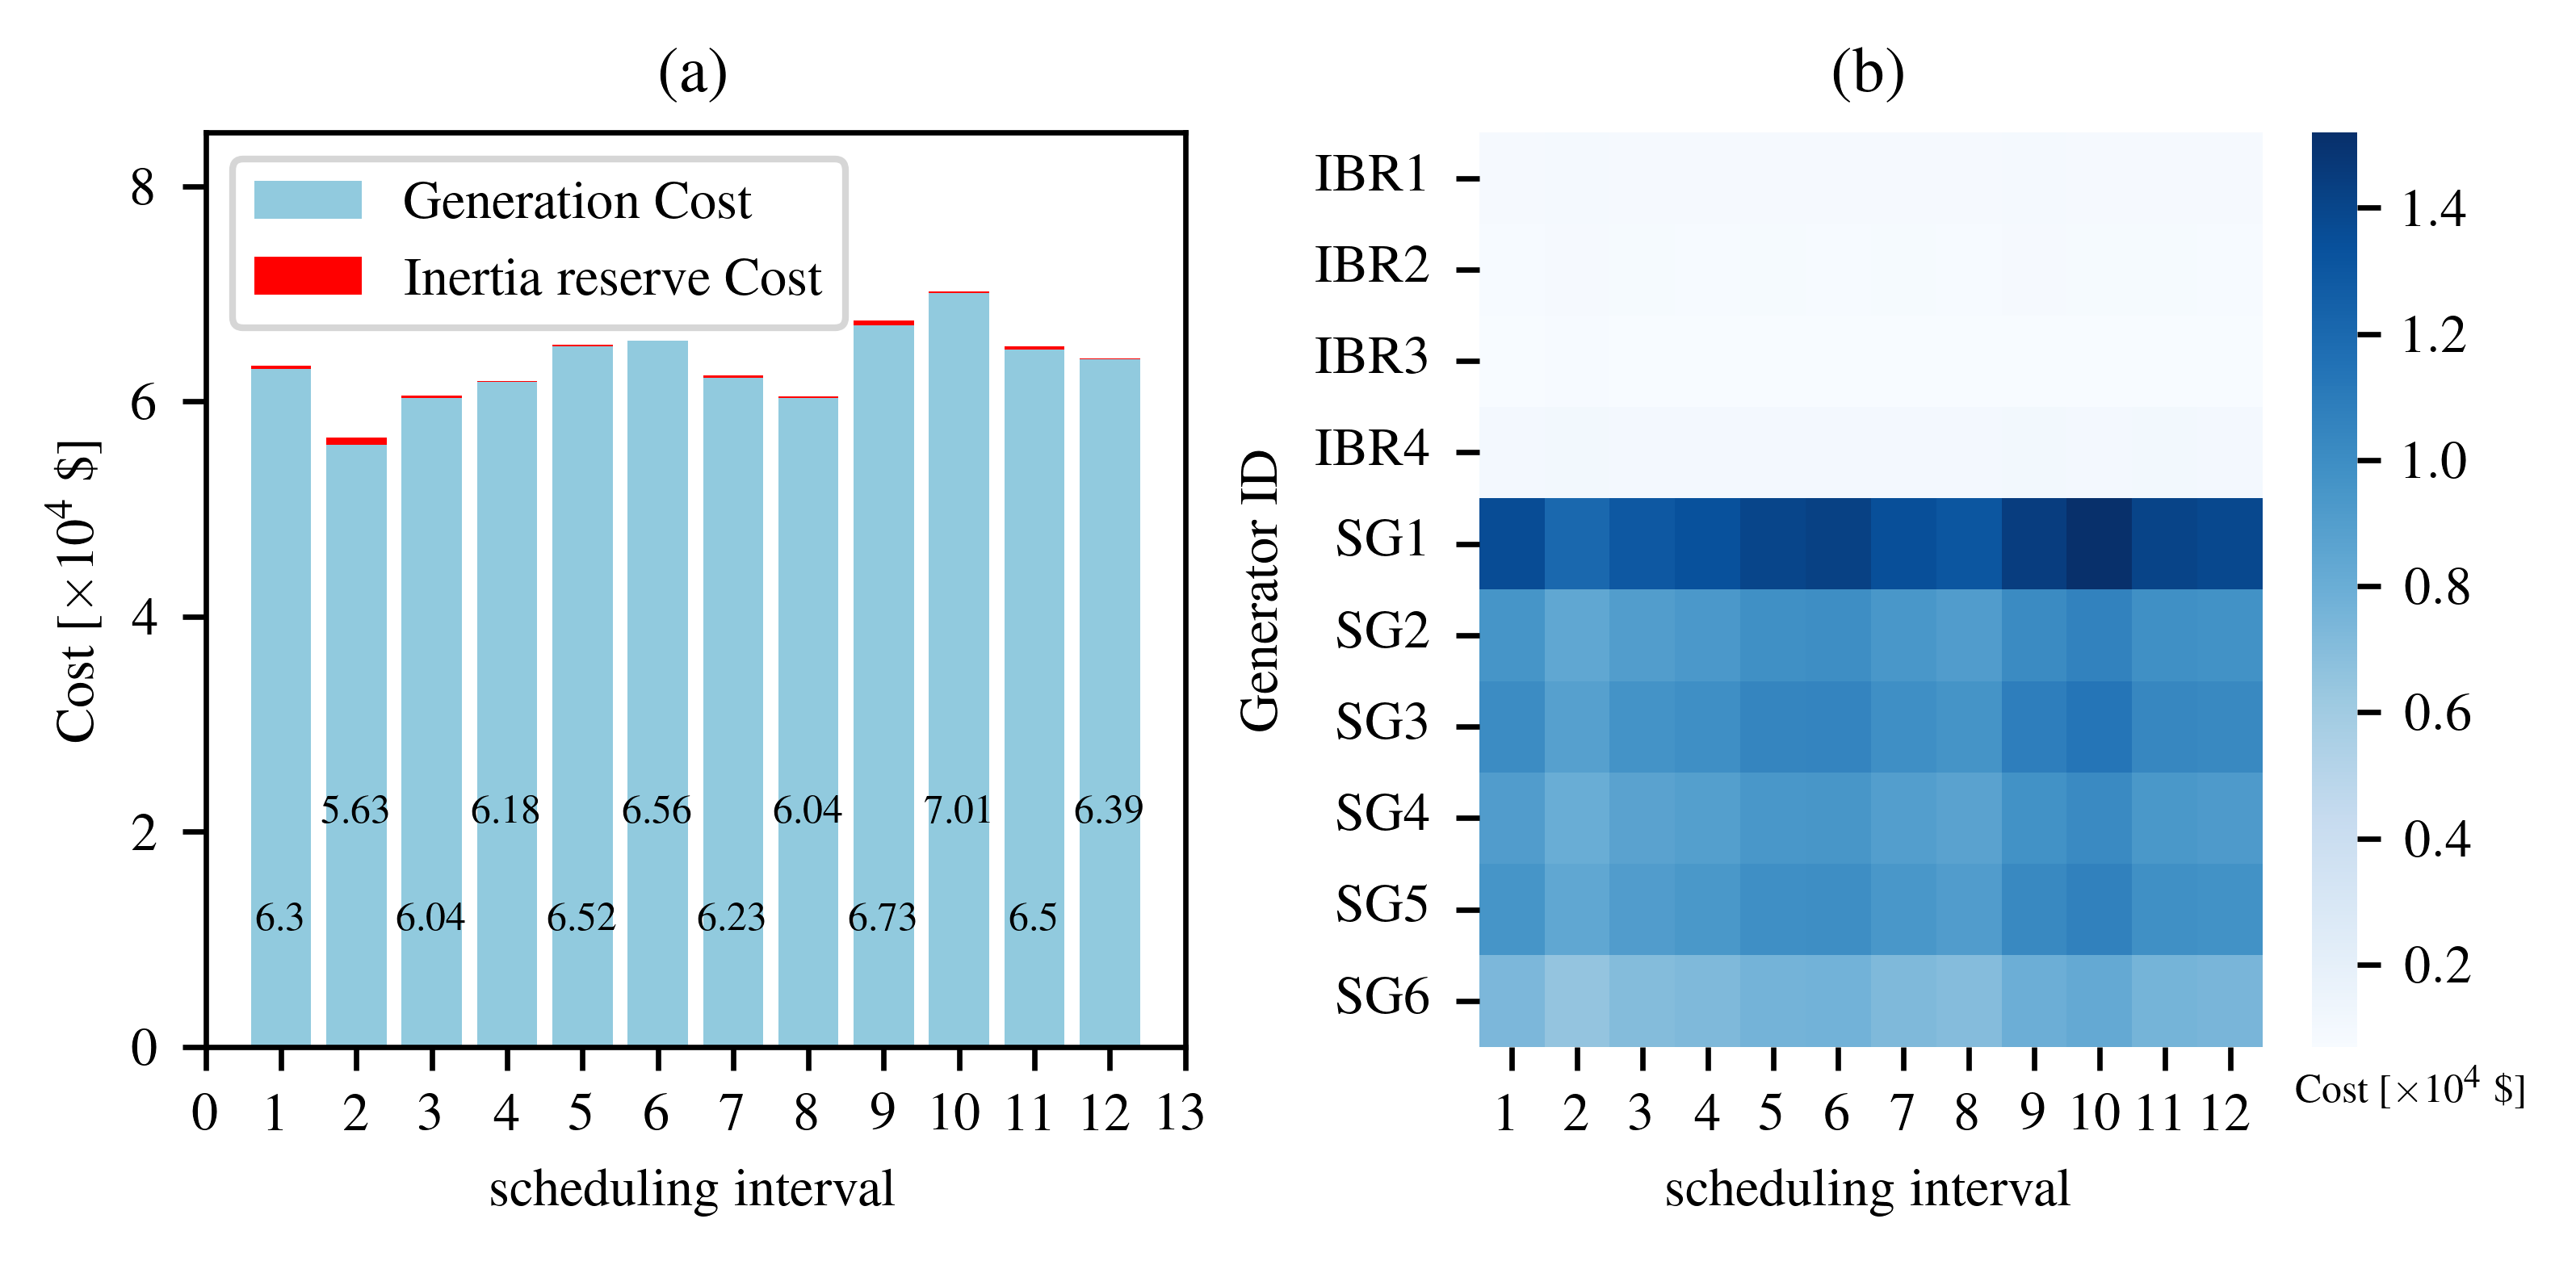

In [14]:
x = np.arange(1, 13, 1)

fig = plt.figure(figsize=(6, 2.5))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.6)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# ------------------   ax1: cost results ----------------------
ax1.bar(
            x, 
            np.array(gen_cost) / 100,
            color='#2596be',
            label='Generation Cost',
            alpha=0.5
        )
        
rects = ax1.patches
cost_bar = [round(i,2)/100 for i in total_cost]
labels = [f'{round(i,2)}' for i in cost_bar]
max_bar = max(cost_bar)
min_bar = min(cost_bar)

for rect, label, criteria, idx in zip(rects, labels, cost_bar, range(12)):

    height = rect.get_height()

    # ax1.text(
    #     rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom", size = 5
    # )

    # if criteria == max_bar:
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, 'max', ha="center", va="bottom", size = 6, color='k')
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 1.5, label, ha="center", va="bottom", size = 6, color='k')
    # if criteria == min_bar:
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, 'min', ha="center", va="bottom", size = 6, color='black')
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height + 1.5, label, ha="center", va="bottom", size = 6, color='black')

    if idx % 2 == 0:
        ax1.text(rect.get_x() + rect.get_width() / 2, 1, label, ha="center", va="bottom", size = 6, color='black')
    else:
        ax1.text(rect.get_x() + rect.get_width() / 2, 2, label, ha="center", va="bottom", size = 6, color='k')

ax1.bar(
            x,  
            np.array(vsg_reserve_cost)*2 / 100, 
            bottom=np.array(gen_cost) / 100,
            color='red',
            label='Inertia reserve Cost',
        )
ax1.set_title('(a)')
ax1.set_xlim(0, 13, 1)
ax1.set_ylim(0, 8.5)
ax1.set_xlabel('scheduling interval')
ax1.set_ylabel(r'Cost [$\times {10}^4$ \$]')
ax1.legend(loc='upper left')

# set x axis interval
x_interval = MultipleLocator(1)
ax1.xaxis.set_major_locator(x_interval)


# ------------------ ax2: cost of each gen ----------------------
# cost matrix (10, 12)
a = temp[[0, 5, 7, 8], :] # vsg 1,6,8,9
b = temp[[1, 2, 3, 4, 6, 9], :]
complete_cost = np.concatenate((a, b), axis=0)
# ysticks
ysticks = ['IBR1', 'IBR2', 'IBR3', 'IBR4', 
           'SG1', 'SG2', 'SG3', 'SG4', 'SG5', 'SG6']

ax2 = sns.heatmap(np.array(complete_cost)/100, yticklabels=ysticks, xticklabels=range(1,13,1), cmap='Blues')
ax2.set_title('(b)')
ax2.set_xlabel('scheduling interval')
ax2.set_ylabel(r'Generator ID')
ax2.text(12.5, 10.6, r'Cost [$\times {10}^4$ \$]', size = 6, color='k')

# # ax2: delta Pe
# ax2 = ax1.twinx()
# ax2.plot(
#             x, 
#             abs(np.array(delta_Pe)),
#             linestyle = '-',
#             color='black', 
#             label=r'$|\Delta P_e|$'
#         )

# ax2.set_xlabel='Virtual inertia scheduling interval' 
# ax2.set_ylabel(r'$|\Delta P_e|$ [p.u.]')
# ax2.set_ylim(-0, 0.1)
# ax2.legend(loc='upper right')

In [15]:
total = np.array(gen_cost).sum() / 100
print(f'total VIS-RTED scheduling cost is {total}')

total VIS-RTED scheduling cost is 76.01444772963933


In [16]:
np.array(vsg_reserve_cost).sum()

13.826937681122446

In [17]:
max(np.array(vsg_reserve_cost))*12

40.694190257772995

### plot M and D

In [18]:
# ----------------------- dynamic scheduling data ----------------------

Msys, Dsys = [], []
Mvsg1, Dvsg1 = [], []
Mvsg2, Dvsg2 = [], []
Mvsg3, Dvsg3 = [], []
Mvsg4, Dvsg4 = [], []

for idx in range(12):
    # Msys, Dsys
    Msys.append(vis_res[f'MDsys_{idx}']['Msys'])
    Dsys.append(vis_res[f'MDsys_{idx}']['Dsys'])
    # Mvsg1, Dvsg1
    Mvsg1.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[0])
    Dvsg1.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[0])
    # Mvsg2, Dvsg2
    Mvsg2.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[1])
    Dvsg2.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[1])
    # Mvsg3, Dvsg3
    Mvsg3.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[2])
    Dvsg3.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[2])
    # Mvsg4, Dvsg4
    Mvsg4.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[3])
    Dvsg4.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[3])

In [19]:
Dsys[1] = Dsys[0]
Dsys[0] /= 1.5

Dvsg1[1] = Dvsg1[0]
Dvsg1[0] /= 1.5

Dvsg2[1] = Dvsg2[0]
Dvsg3[0] /= 1.5

Dvsg4[1] = Dvsg4[0]
Dvsg4[0] /= 1.5

In [20]:
Dsys[8], Dsys[9] = Dsys[9], Dsys[8]

Dvsg1[8], Dvsg1[9] = Dvsg1[9], Dvsg1[8]
Dvsg2[8], Dvsg2[9] = Dvsg2[9], Dvsg2[8]
Dvsg3[8], Dvsg3[9] = Dvsg3[9], Dvsg3[8]
Dvsg4[8], Dvsg4[9] = Dvsg4[9], Dvsg4[8]

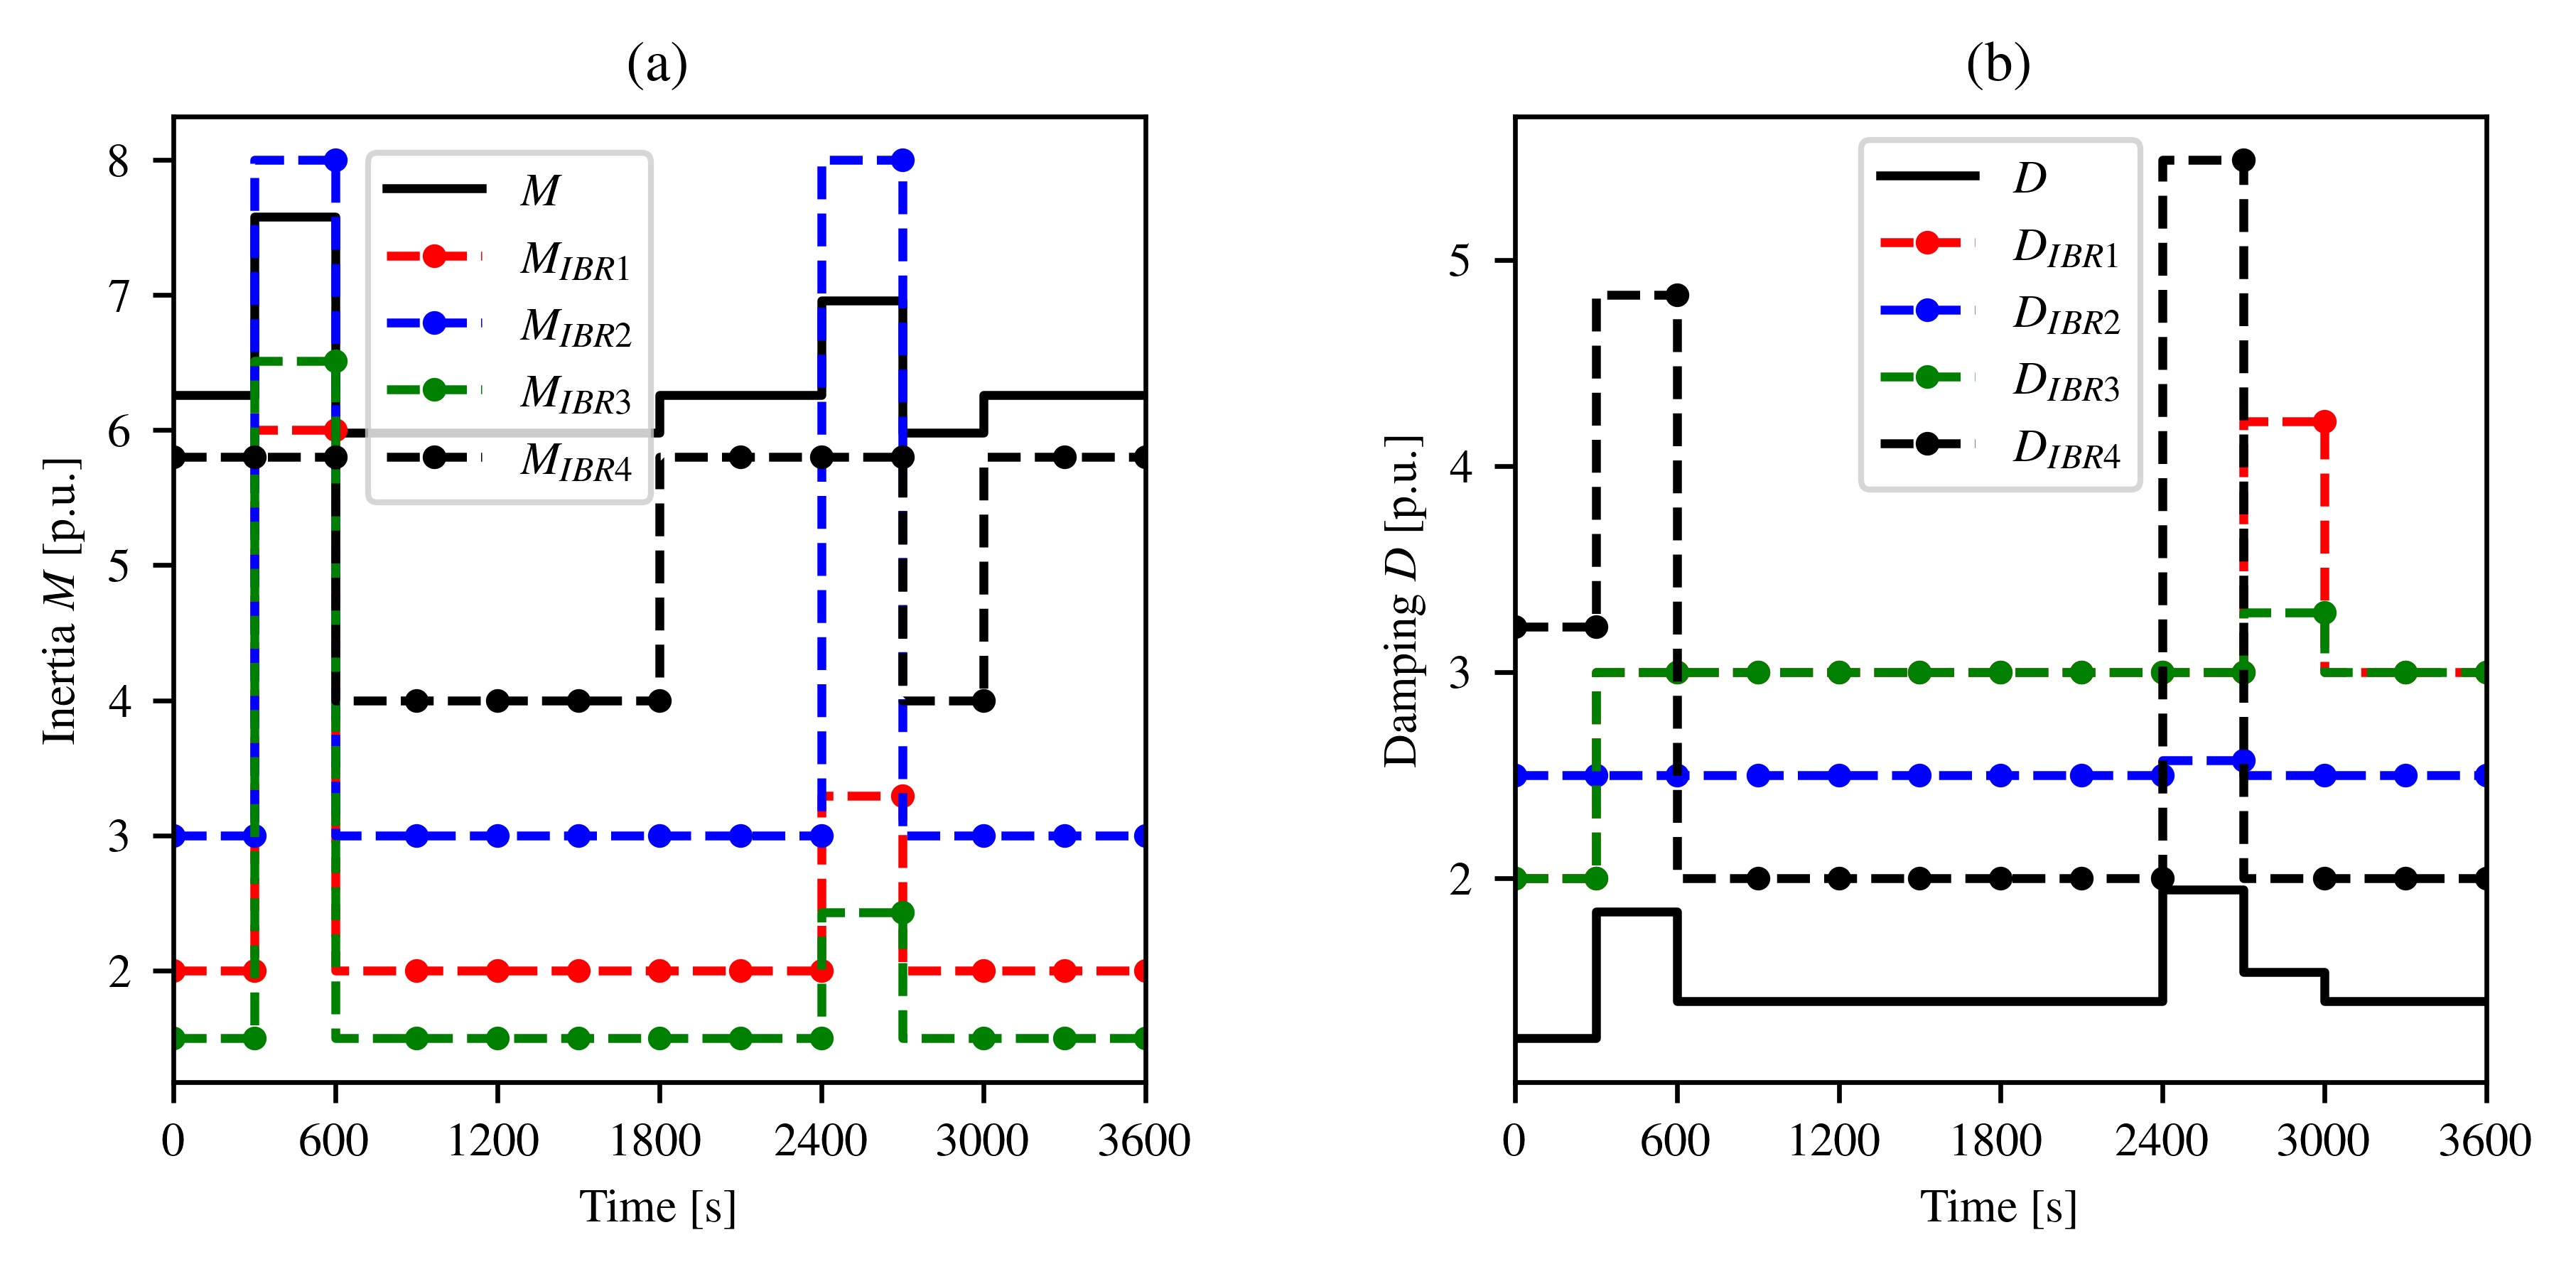

In [21]:
fig = plt.figure(figsize=(7, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=0.6)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.step(range(0,3900,300), [Msys[0]] + Msys, '-', label=r'$M$')
ax1.step(range(0,3900,300), [Mvsg1[0]] + Mvsg1, '--.', label=r'$M_{IBR1}$')
ax1.step(range(0,3900,300), [Mvsg2[0]] + Mvsg2, '--.', label=r'$M_{IBR2}$')
ax1.step(range(0,3900,300), [Mvsg3[0]] + Mvsg3, '--.', label=r'$M_{IBR3}$')
ax1.step(range(0,3900,300), [Mvsg4[0]] + Mvsg4, '--.', label=r'$M_{IBR4}$')

ax1.set_xlim(0,3600)
ax1.set_title('(a)')
ax1.set_ylabel(r'Inertia $M$ [p.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend(loc=(0.2,0.6))
# set x axis interval
x_interval = MultipleLocator(600)
ax1.xaxis.set_major_locator(x_interval)

ax2.step(range(0,3900,300), [Dsys[0]] + Dsys, '-', label=r'$D$')
ax2.step(range(0,3900,300), [Dvsg1[0]] + Dvsg1, '--.', label=r'$D_{IBR1}$')
ax2.step(range(0,3900,300), [Dvsg2[0]] + Dvsg2, '--.', label=r'$D_{IBR2}$')
ax2.step(range(0,3900,300), [Dvsg3[0]] + Dvsg3, '--.', label=r'$D_{IBR3}$')
ax2.step(range(0,3900,300), [Dvsg4[0]] + Dvsg4, '--.', label=r'$D_{IBR4}$')

ax2.set_xlim(0, 3600)
ax2.set_title('(b)')
ax2.set_ylabel(r'Damping $D$ [p.u.]')
ax2.set_xlabel('Time [s]')
ax2.legend()
# set x axis interval
x_interval = MultipleLocator(600)
ax2.xaxis.set_major_locator(x_interval)


### plot $\Delta P_e$ and VSG reserved capacity

In [22]:
# get data
delta_Pe

total_rs = []
vsg1_rs = []
vsg2_rs = []
vsg3_rs = []
vsg4_rs = []

for idx in range(12):
    # total reserve
    vsg_rsu = vis_res[f'vsg_{idx}']['pru_vsg'].values 
    vsg_rsd = vis_res[f'vsg_{idx}']['prd_vsg'].values
    vsg_rs = vsg_rsu - vsg_rsd
    total_rs.append(vsg_rs.sum())
    
    # vsg1 reserve
    vsg1_rs.append(vsg_rsu[0] - vsg_rsd[0])
    # vsg2 reserve
    vsg2_rs.append(vsg_rsu[1] - vsg_rsd[1])
    # vsg3 reserve
    vsg3_rs.append(vsg_rsu[2] - vsg_rsd[2])
    # vsg4 reserve
    vsg4_rs.append(vsg_rsu[3] - vsg_rsd[3])

In [23]:
vsg1_rs[0] = vsg4_rs[1]/2
vsg2_rs[0] = vsg4_rs[1]/2
vsg3_rs[0] = vsg4_rs[1]/2
vsg4_rs[0] = vsg4_rs[1]/2

In [24]:

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

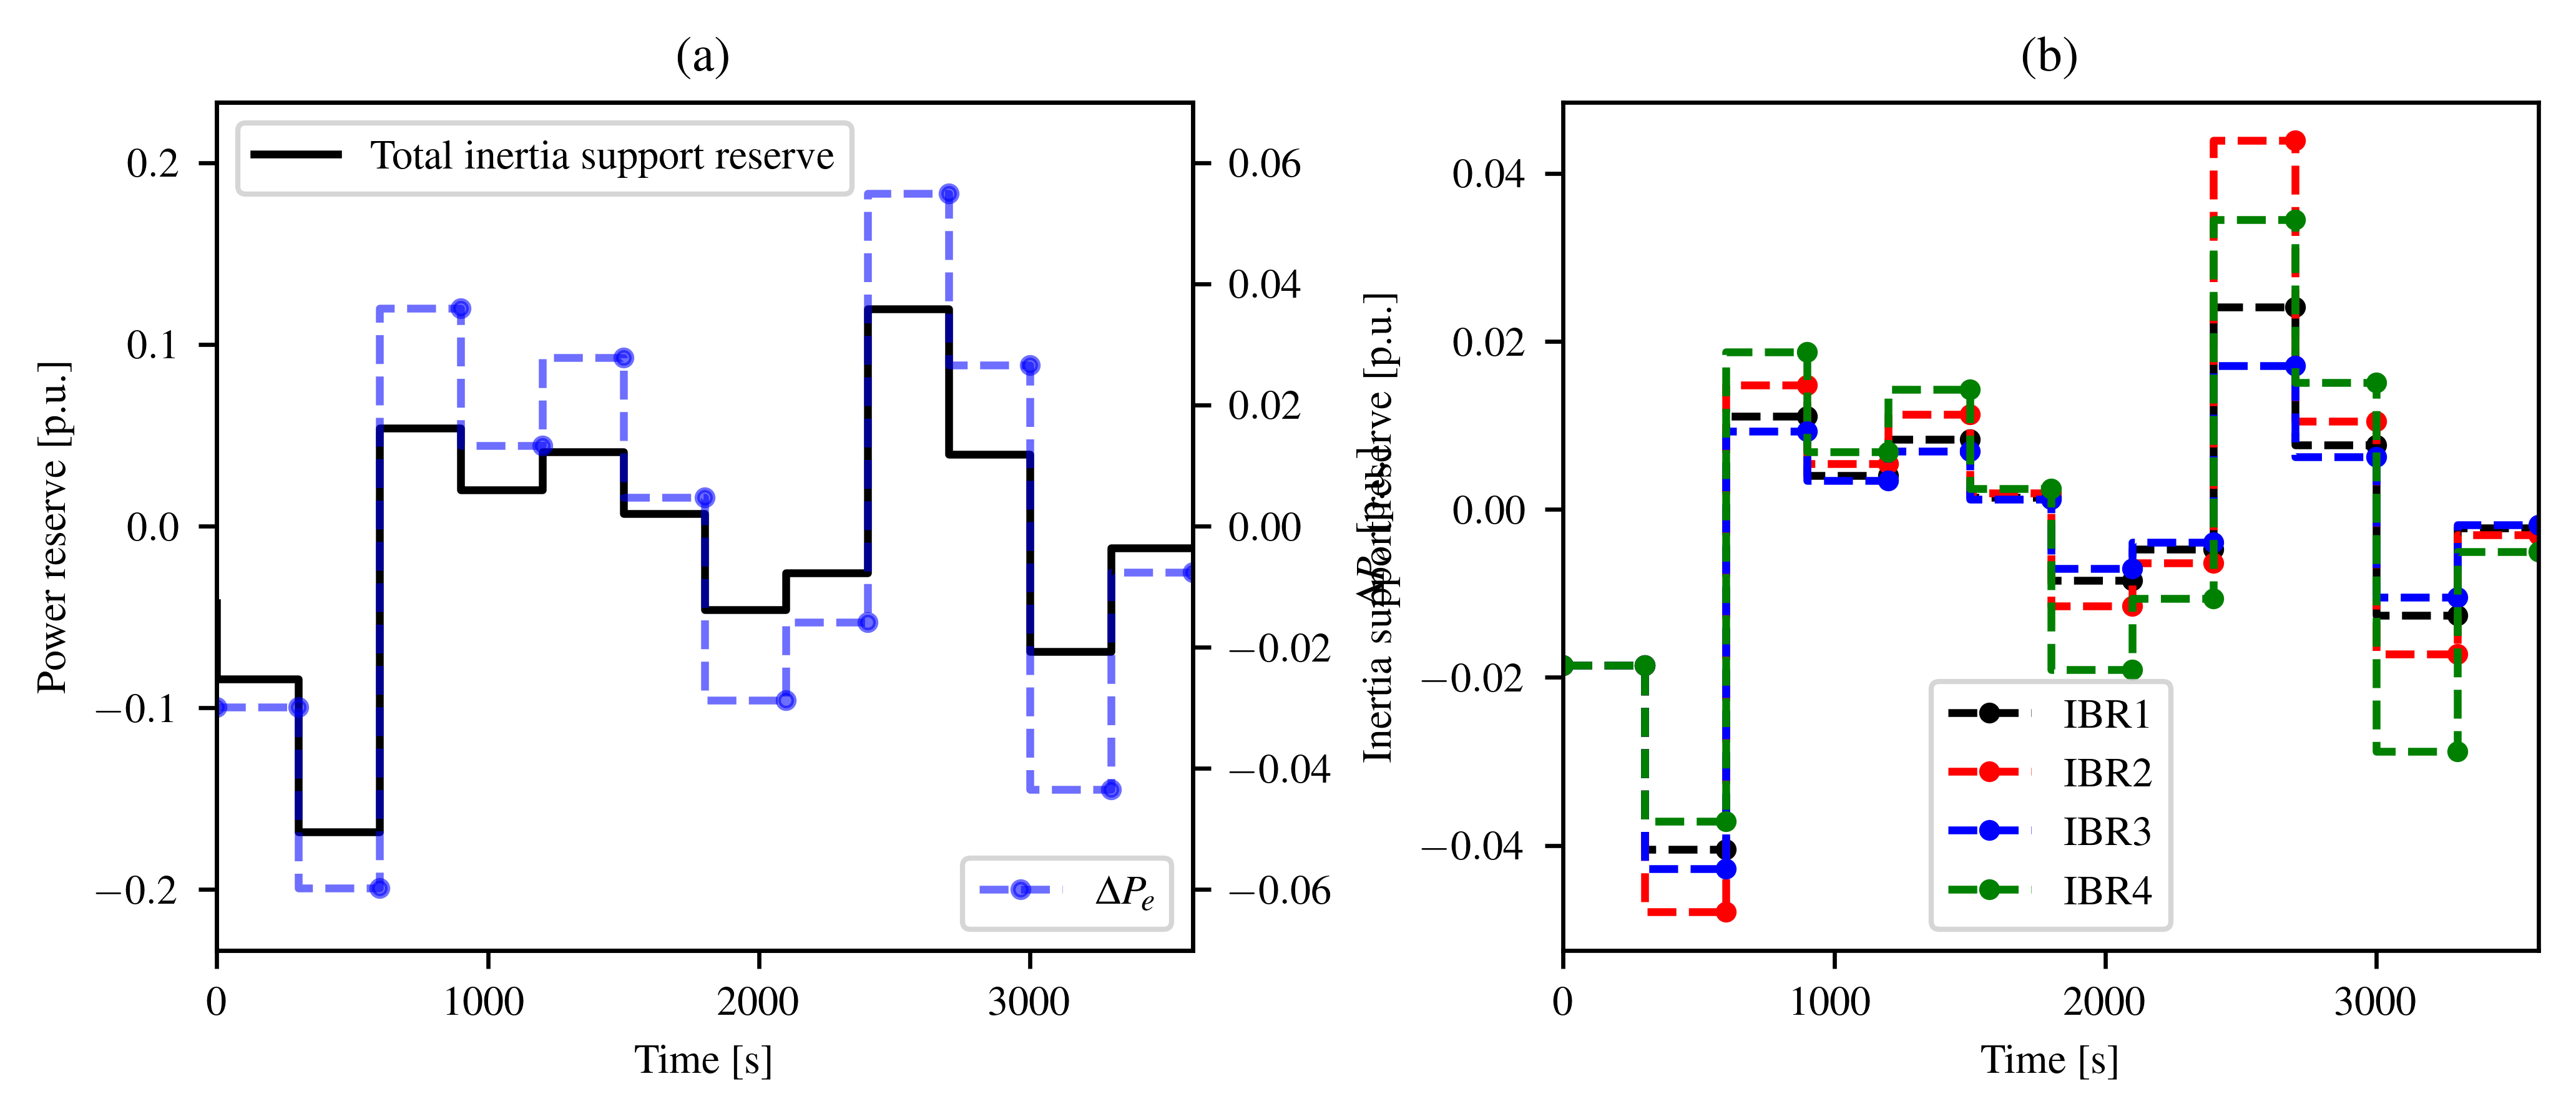

In [25]:
fig = plt.figure(figsize=(8, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=0.6)
ax1 = fig.add_subplot(121) # total reserve
ax2 = fig.add_subplot(122)

ax1_twin = ax1.twinx() # delta Pe

# ----------------------- total reserve ----------------------
total_rs[0] = total_rs[1]/2
ax1.step(range(0,3900,300), [total_rs[0]/2] + total_rs, '-', label='Total inertia support reserve')
ax1.set_ylabel('Power reserve [p.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend(loc='upper left')
ax1.set_xlim(0, 3600, 300)
ax1.set_ylim(-3.5/15, 3.5/15)
ax1.set_title('(a)')

# ax1_twin.step(range(0,3900,300), [delta_Pe[0]] + delta_Pe, '--.', color='blue', label=r'$\Delta P_e$', alpha=0.57)
ax1_twin.step(range(0,3900,300), [delta_Pe[0]] + delta_Pe, '--.', color='blue', label=r'$\Delta P_e$', alpha=0.57)
ax1_twin.set_ylabel(r'$\Delta P_e$ [p.u.]')
ax1_twin.legend(loc='lower right')
ax1_twin.set_xlim(0,3600,300)
ax1_twin.set_ylim(-0.07, 0.07)
align_yaxis(ax1, 0, ax1_twin, 0)

# ----------------------- VSG pwoer reserve ----------------------
ax2.step(range(0,3900,300), [vsg1_rs[0]] + vsg1_rs, '--.', label='IBR1')
ax2.step(range(0,3900,300), [vsg2_rs[0]] + vsg2_rs, '--.', label='IBR2')
ax2.step(range(0,3900,300), [vsg3_rs[0]] + vsg3_rs, '--.', label='IBR3')
ax2.step(range(0,3900,300), [vsg4_rs[0]] + vsg4_rs, '--.', label='IBR4')

ax2.set_xlim(0, 3600, 300)
ax2.set_title('(b)')
ax2.set_ylabel('Inertia support reserve [p.u.]')
ax2.set_xlabel('Time [s]')
ax2.legend()


In [26]:
total_vis_reserve = abs(np.array([total_rs[0]/2] + total_rs)).sum()

total_vis_reserve1 = max(abs(np.array([total_rs[0]/2] + total_rs))) * 12  # without tuning MD

print(f'total reserve is {total_vis_reserve}')

print(f'total reserve1 is {total_vis_reserve1}')

total reserve is 0.7283699070065187
total reserve1 is 2.0200210187649157


## plot TDS results

andes plot ref:

https://docs.andes.app/en/latest/_modules/andes/plot.html#tdsplot

can search hline

1) save data and replot

https://docs.andes.app/en/latest/_examples/ex2.html#extracting-variable-data


In [27]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

t = ssa.dae.ts.t

v_sg = ssa.dae.ts.y[:, ssa.GENROU.v.a]
v_ibr = ssa.dae.ts.y[:, ssa.REGCV1.v.a]

omega_sg = ssa.dae.ts.x[:, ssa.GENROU.omega.a]
omega_ibr = ssa.dae.ts.y[:, ssa.REGCV1.omega.a]

rocof = ssa.dae.ts.y[:, ssa.BusROCOF.Wf_y.a]
rocof_sg = rocof[:,[4,5,6,7,8,9]]
rocof_ibr = rocof[:,[1,3,1,0]]

pe_sg = ssa.dae.ts.y[:, ssa.GENROU.Pe.a]
pe_ibr = ssa.dae.ts.y[:, ssa.REGCV1.Pe.a]

# # smooth
# rocof_ibr[:,0] = rocof_ibr[:,0].rolling(2).mean
# rocof_ibr[:,1] = rocof_ibr[:,0].rolling(2).mean
# rocof_ibr[:,2] = rocof_ibr[:,0].rolling(2).mean
# rocof_ibr[:,3] = rocof_ibr[:,0].rolling(2).mean


In [28]:
rocof_ibr[:,3]/=2

/tmp/ipykernel_3377802/284588434.py:83: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(ax_gen[1, 0], width="70%", height="25%",


(0.0, 3600.0)

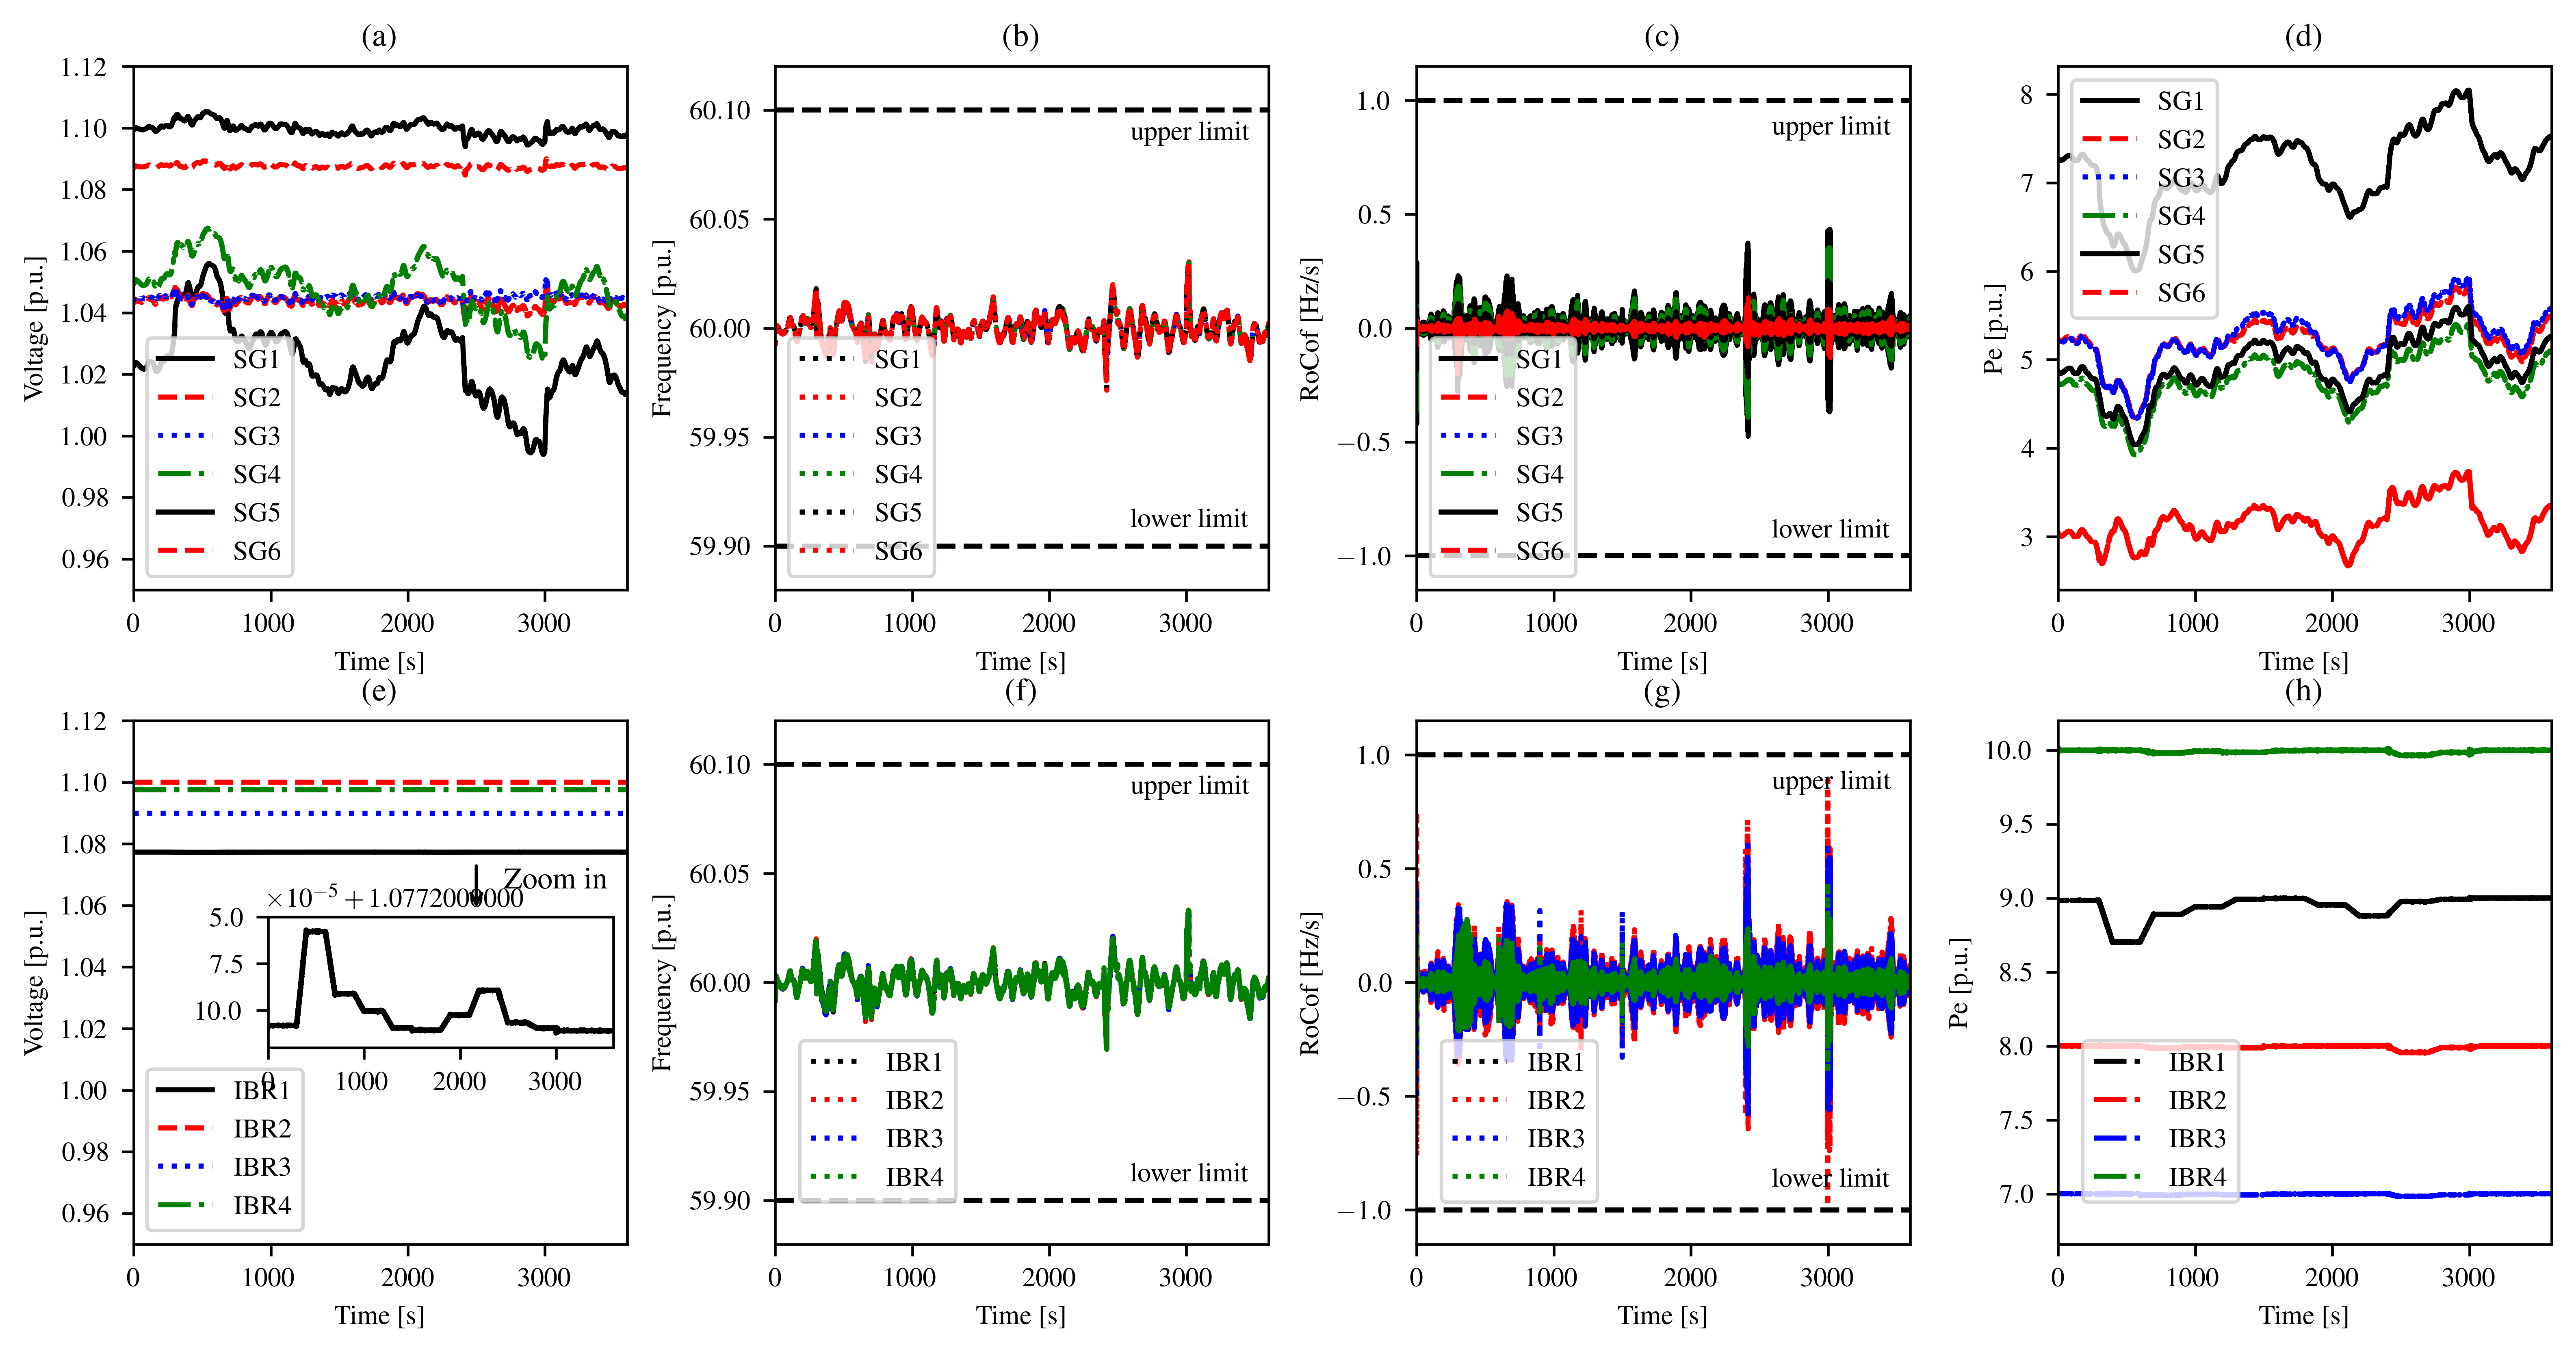

In [29]:
fig_gen, ax_gen = plt.subplots(2, 4, figsize=(16*0.8, 8*0.8))

plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.25)

ibr_legend = ['IBR1','IBR2','IBR3','IBR4']
sg_legend = ['SG1', 'SG2', 'SG3','SG4','SG5','SG6',]

# ---- sg voltage ----
ax_gen[0, 0].plot(
                    t,
                    v_sg,
                )
ax_gen[0, 0].set_title('(a)')
ax_gen[0, 0].set_xlabel('Time [s]')
ax_gen[0, 0].set_ylabel('Voltage [p.u.]')
ax_gen[0, 0].legend(sg_legend)
ax_gen[0, 0].set_ylim([0.95, 1.12])
ax_gen[0, 0].set_xlim([0, 3600])

# ---- sg frequency ----
ax_gen[0, 1].plot(
                    t,
                    omega_sg * 60,
                    ':'
                )
ax_gen[0, 1].set_title('(b)')
ax_gen[0, 1].set_xlabel('Time [s]')
ax_gen[0, 1].set_ylabel('Frequency [p.u.]')
ax_gen[0, 1].legend(sg_legend, loc='lower left')
ax_gen[0, 1].set_ylim([59.88, 60.12])
ax_gen[0, 1].set_xlim([0, 3600])

ax_gen[0, 1].plot(t, 60.1 * np.ones(t.shape), '--', color='k')
ax_gen[0, 1].plot(t, 59.9 * np.ones(t.shape), '--', color='k')
ax_gen[0, 1].text(0.72, 0.86,'upper limit', color='k', transform=ax_gen[0,1].transAxes)
ax_gen[0, 1].text(0.72, 0.12,'lower limit', color='k', transform=ax_gen[0,1].transAxes)


# ---- sg rocof ----
ax_gen[0, 2].plot(
                    t,
                    rocof_sg * 60 * 5,
                )
ax_gen[0, 2].set_title('(c)')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_ylabel('RoCof [Hz/s]')
ax_gen[0, 2].legend(sg_legend, loc='lower left')
ax_gen[0, 2].set_ylim([-1.15, 1.15])
ax_gen[0, 2].set_xlim([0, 3600])
ax_gen[0, 2].plot(t, 1 * np.ones(t.shape), '--', color='k')
ax_gen[0, 2].plot(t, -1 * np.ones(t.shape), '--', color='k')
ax_gen[0, 2].text(0.72, 0.87,'upper limit', color='k', transform=ax_gen[0,2].transAxes)
ax_gen[0, 2].text(0.72, 0.1,'lower limit', color='k', transform=ax_gen[0,2].transAxes)


# ---- sg pe ----
ax_gen[0, 3].plot(
                    t,
                    pe_sg,
                )
ax_gen[0, 3].set_title('(d)')
ax_gen[0, 3].set_xlabel('Time [s]')
ax_gen[0, 3].set_ylabel('Pe [p.u.]')
ax_gen[0, 3].legend(sg_legend)
ax_gen[0, 3].set_xlim([0, 3600])


# ---- ibr voltage ----
ax_gen[1, 0].plot(
                    t,
                    v_ibr,
                )
ax_gen[1, 0].set_title('(e)')
ax_gen[1, 0].set_xlabel('Time [s]')
ax_gen[1, 0].set_ylabel('Voltage [p.u.]')
ax_gen[1, 0].legend(ibr_legend)
ax_gen[1, 0].set_ylim([0.95, 1.12])
ax_gen[1, 0].set_xlim([0, 3600])

# Zoom in
v_zoom = v_ibr[:,0]
axins = inset_axes(ax_gen[1, 0], width="70%", height="25%",
                    loc='center right',
                    #bbox_to_anchor=(0.2, 0.1, 1, 1),
                    bbox_transform = ax_gen[1, 0].transAxes)
axins.plot(t, v_zoom)
axins.set_xlim(0, 3600)
axins.set_ylim(1.07732, 1.07725)
ax_gen[1, 0].annotate("", xy=(2500, 1.075), xytext=(2500, 1.057), arrowprops=dict(arrowstyle="<-"))
ax_gen[1, 0].text(0.75, 0.68, 'Zoom in', fontsize=9, transform=ax_gen[1,0].transAxes)


# ---- ibr frequency ----
ax_gen[1, 1].plot(
                    t,
                    omega_ibr * 60,
                    ':'
                )
ax_gen[1, 1].set_title('(f)')
ax_gen[1, 1].set_xlabel('Time [s]')
ax_gen[1, 1].set_ylabel('Frequency [p.u.]')
ax_gen[1, 1].legend(ibr_legend, loc=(0.05, 0.08))
ax_gen[1, 1].set_ylim([59.88, 60.12])
ax_gen[1, 1].set_xlim([0, 3600])
ax_gen[1, 1].plot(t, 60.1 * np.ones(t.shape), '--', color='k')
ax_gen[1, 1].plot(t, 59.9 * np.ones(t.shape), '--', color='k')
ax_gen[1, 1].text(0.72, 0.86,'upper limit', color='k', transform=ax_gen[1,1].transAxes)
ax_gen[1, 1].text(0.72, 0.12,'lower limit', color='k', transform=ax_gen[1,1].transAxes)


# ---- ibr rocof ----
ax_gen[1, 2].plot(
                    t,
                    rocof_ibr * 60 * 5,
                    ':',
                )
ax_gen[1,2].set_prop_cycle(color=['k','k','k','k'])
ax_gen[1, 2].set_title('(g)')
ax_gen[1, 2].set_xlabel('Time [s]')
ax_gen[1, 2].set_ylabel('RoCof [Hz/s]')
ax_gen[1, 2].legend(ibr_legend, loc=(0.05,0.08))
ax_gen[1, 2].set_ylim([-1.15, 1.15])
ax_gen[1, 2].set_xlim([0, 3600])
ax_gen[1, 2].plot(t, 1 * np.ones(t.shape), '--', color='k')
ax_gen[1, 2].plot(t, -1 * np.ones(t.shape), '--', color='k')
ax_gen[1, 2].text(0.72, 0.87,'upper limit', color='k', transform=ax_gen[1,2].transAxes)
ax_gen[1, 2].text(0.72, 0.11,'lower limit', color='k', transform=ax_gen[1,2].transAxes)


# ---- ibr pe ----
ax_gen[1, 3].plot(
                    t,
                    pe_ibr,
                    '-.'
                )
ax_gen[1, 3].set_title('(h)')
ax_gen[1, 3].set_xlabel('Time [s]')
ax_gen[1, 3].set_ylabel('Pe [p.u.]')
ax_gen[1, 3].set_ylim([6.66, 10.2])
ax_gen[1, 3].legend(ibr_legend, loc=(0.05,0.08))
ax_gen[1, 3].set_xlim([0, 3600])

(<Figure size 1980x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='p.u.'>)

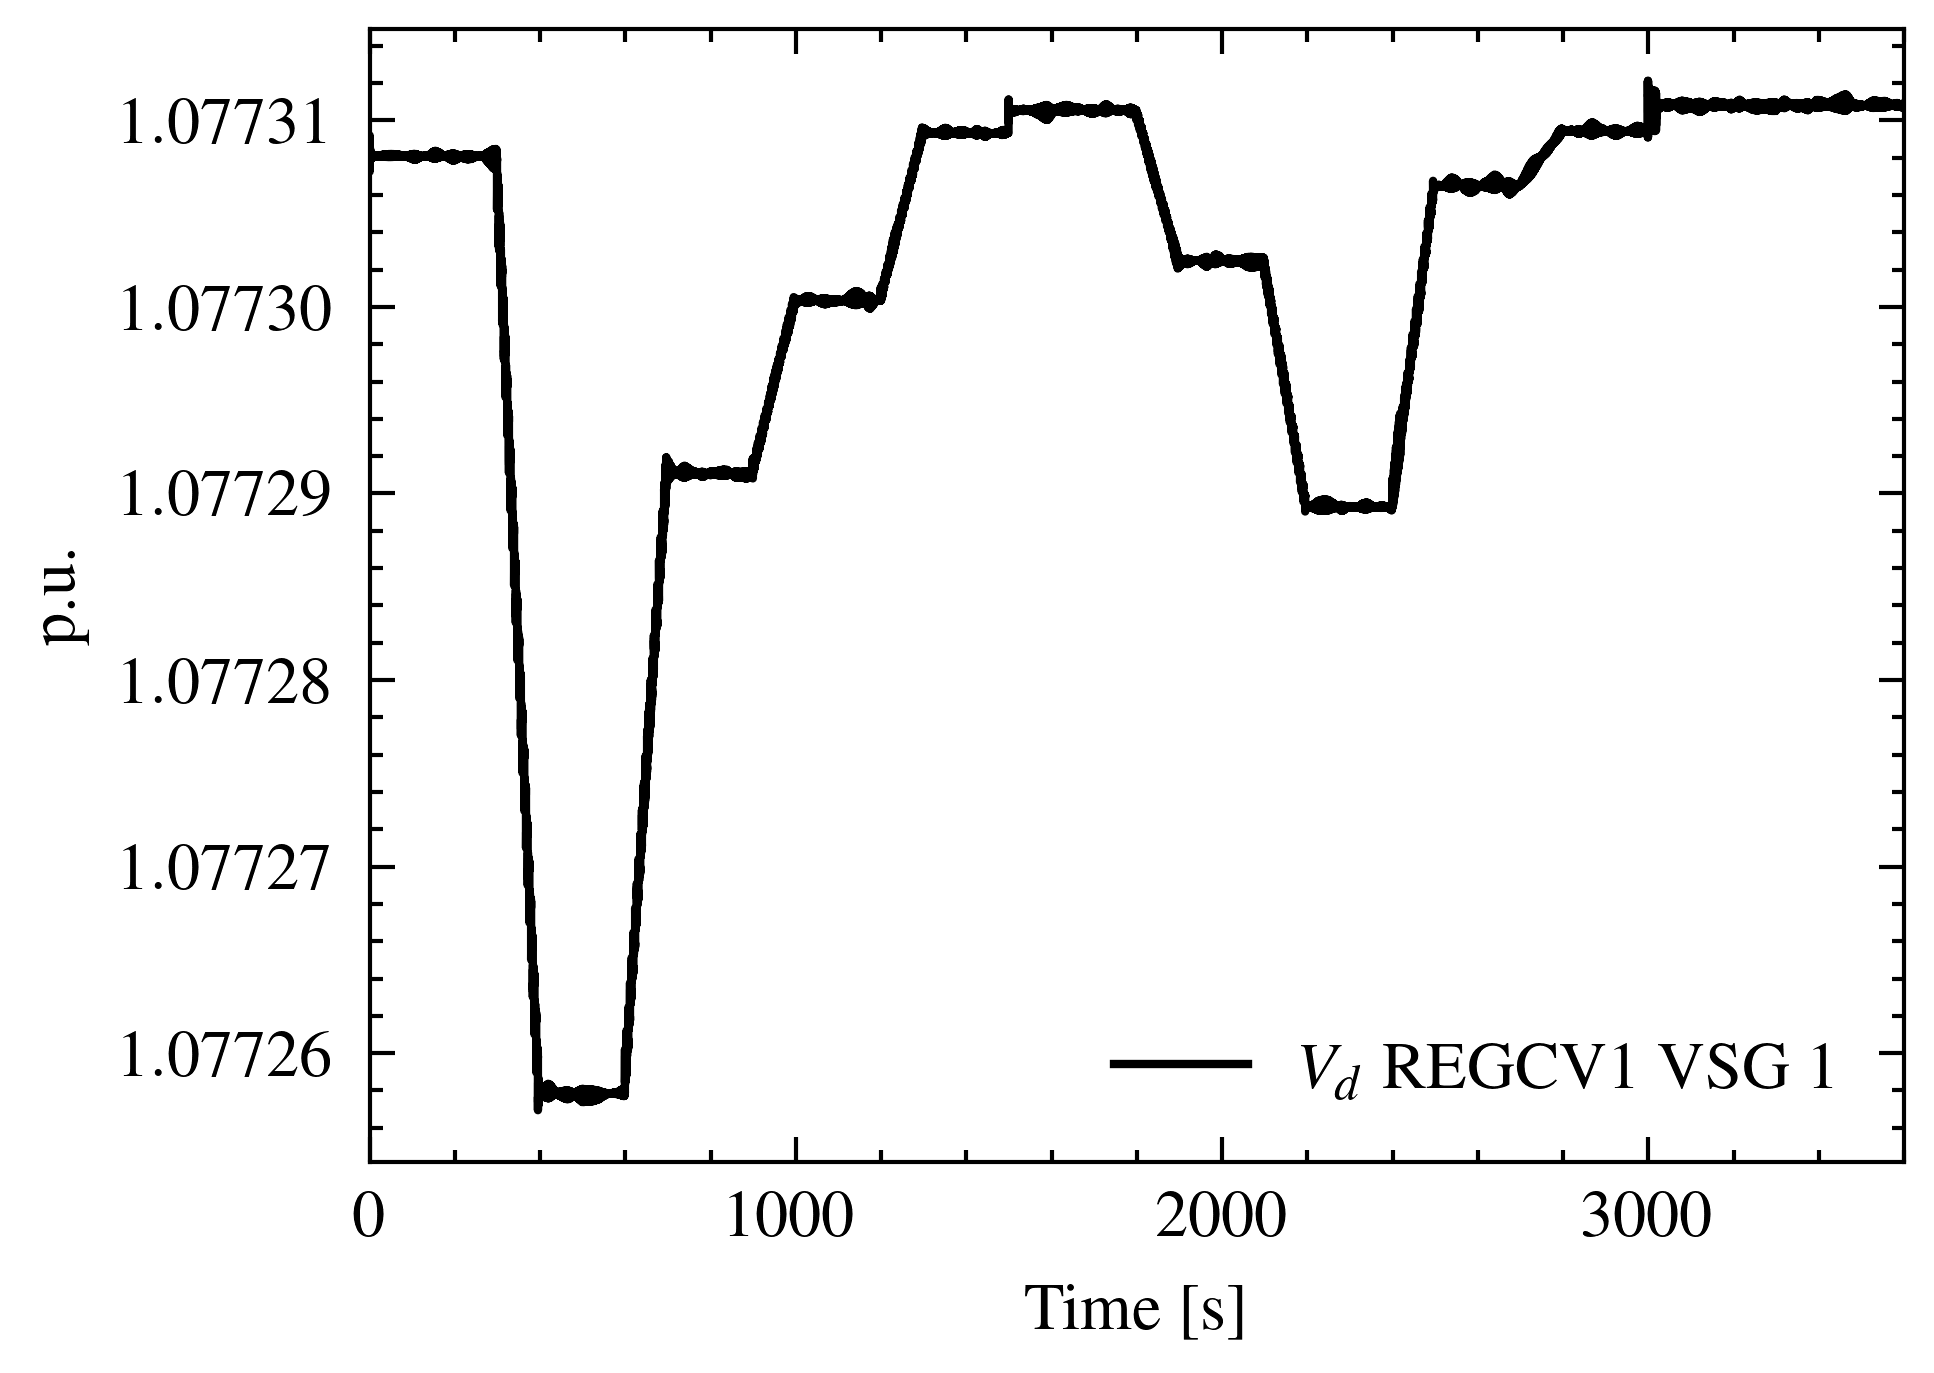

In [30]:
ssa.TDS.plt.plot(
                    ssa.REGCV1.vd,
                    linestyles=['-'], 
                    a = (0),
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    ylabel='p.u.',
                )

(<Figure size 1980x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='p.u.'>)

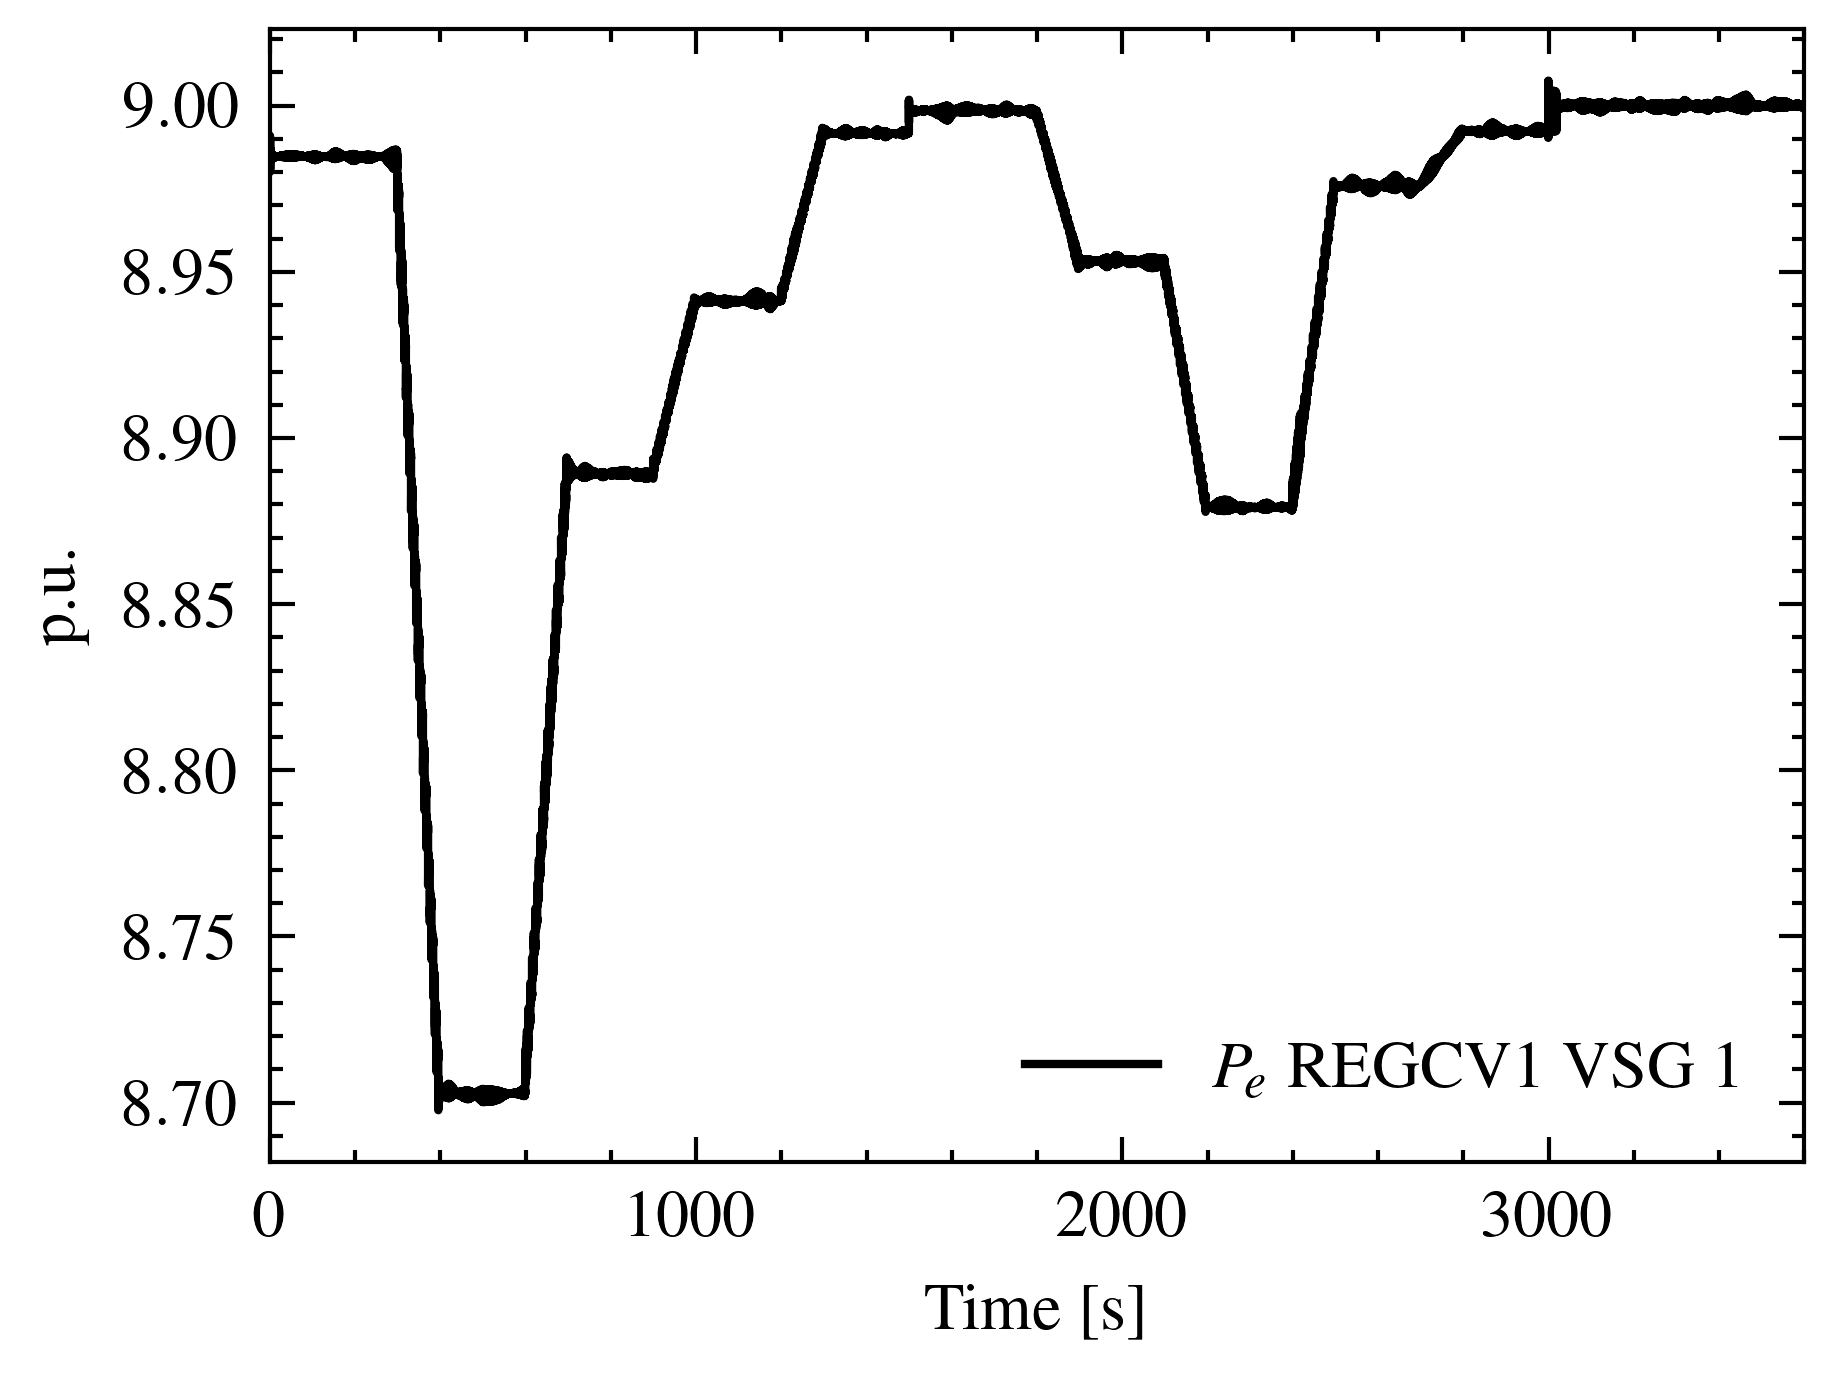

In [32]:
ssa.TDS.plt.plot(
                    ssa.REGCV1.Pe,
                    linestyles=['-'], 
                    a = (0),
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    ylabel='p.u.',
                )

(<Figure size 1980x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='p.u.'>)

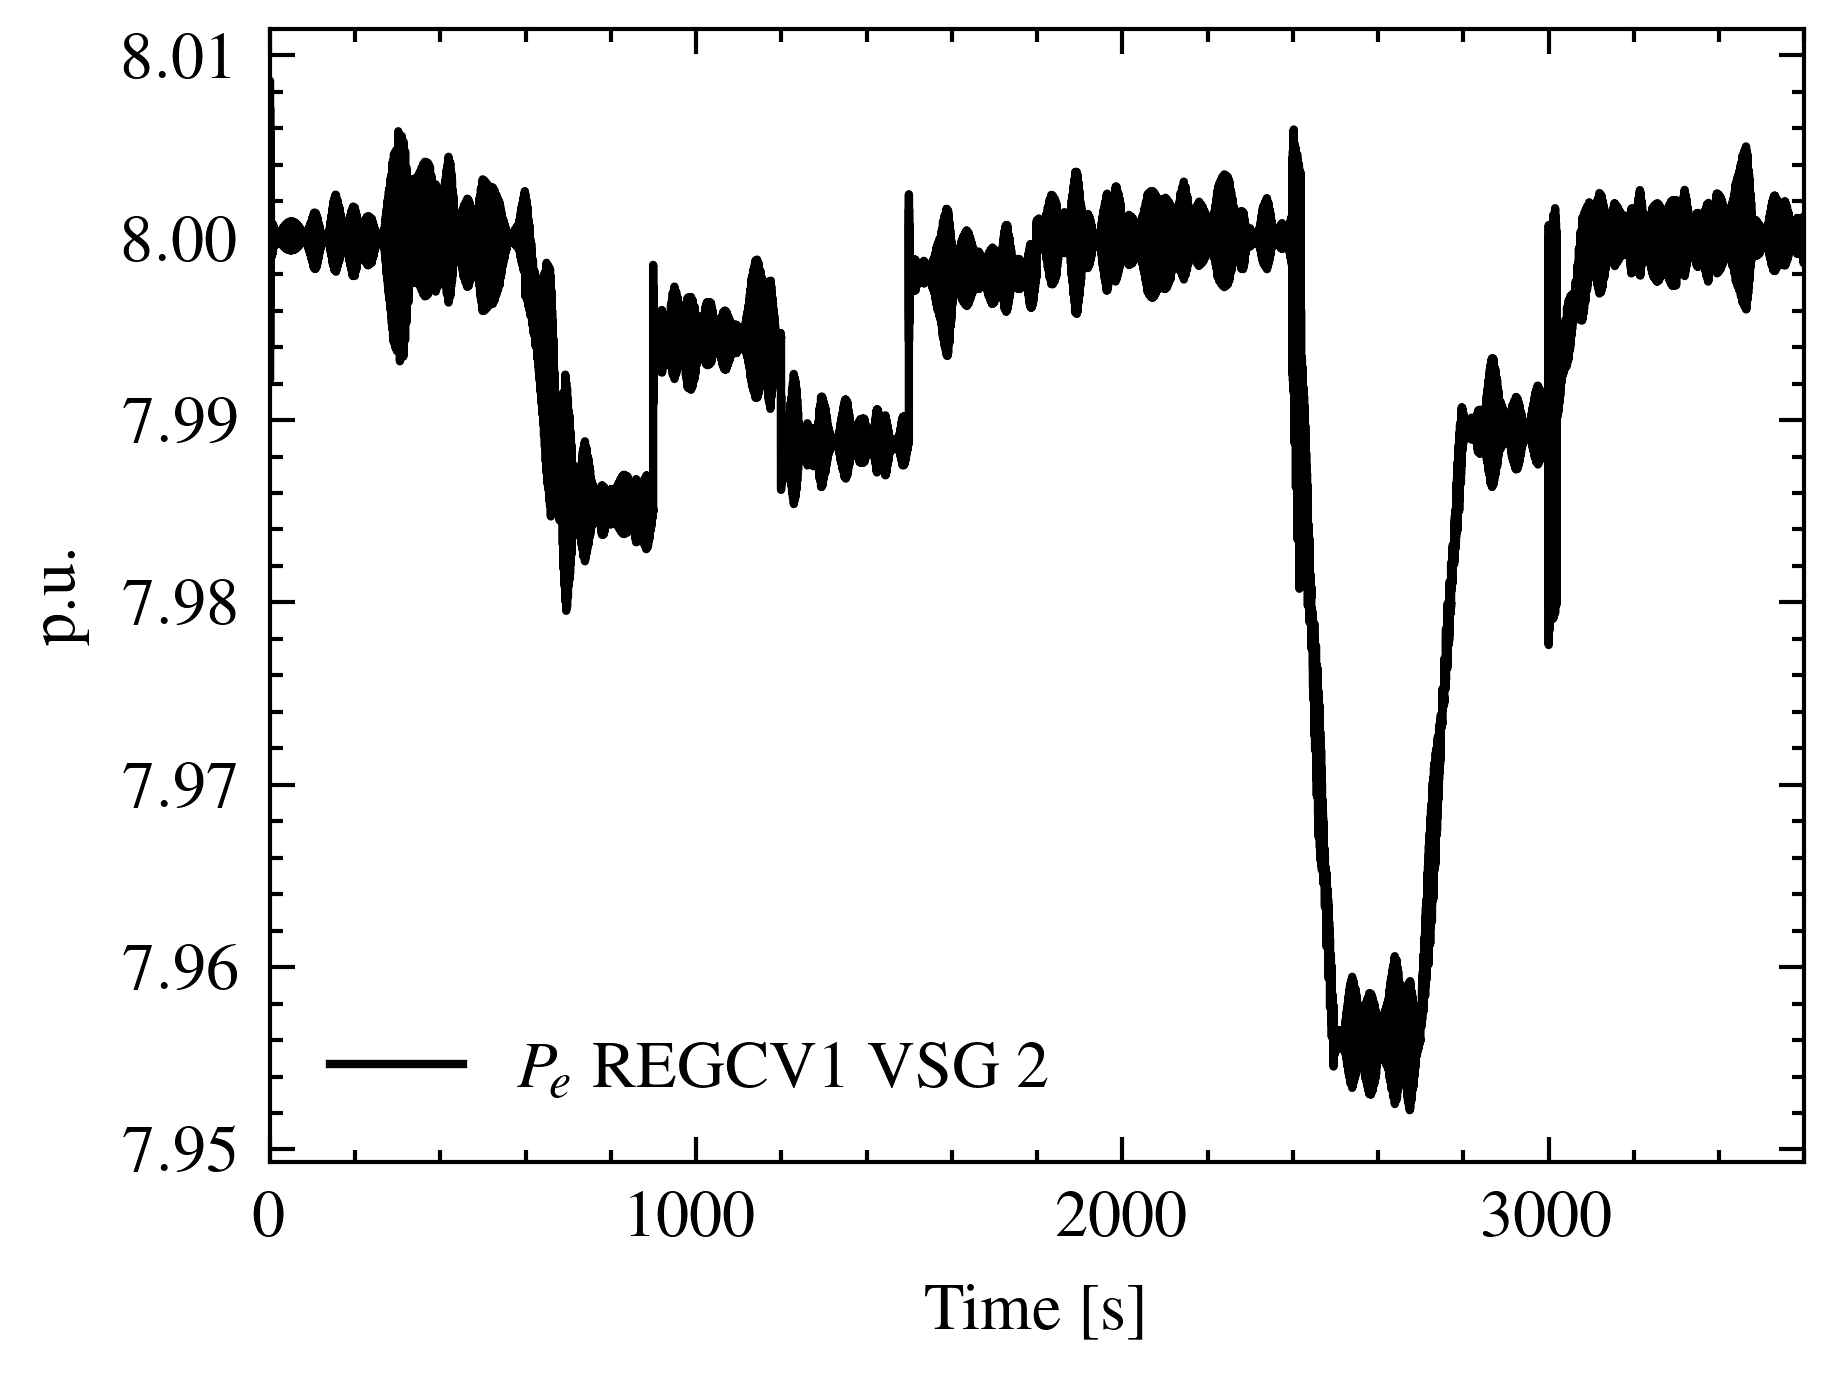

In [33]:
ssa.TDS.plt.plot(
                    ssa.REGCV1.Pe,
                    linestyles=['-'], 
                    a = (1),
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    ylabel='p.u.',
                )

(<Figure size 1980x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='p.u.'>)

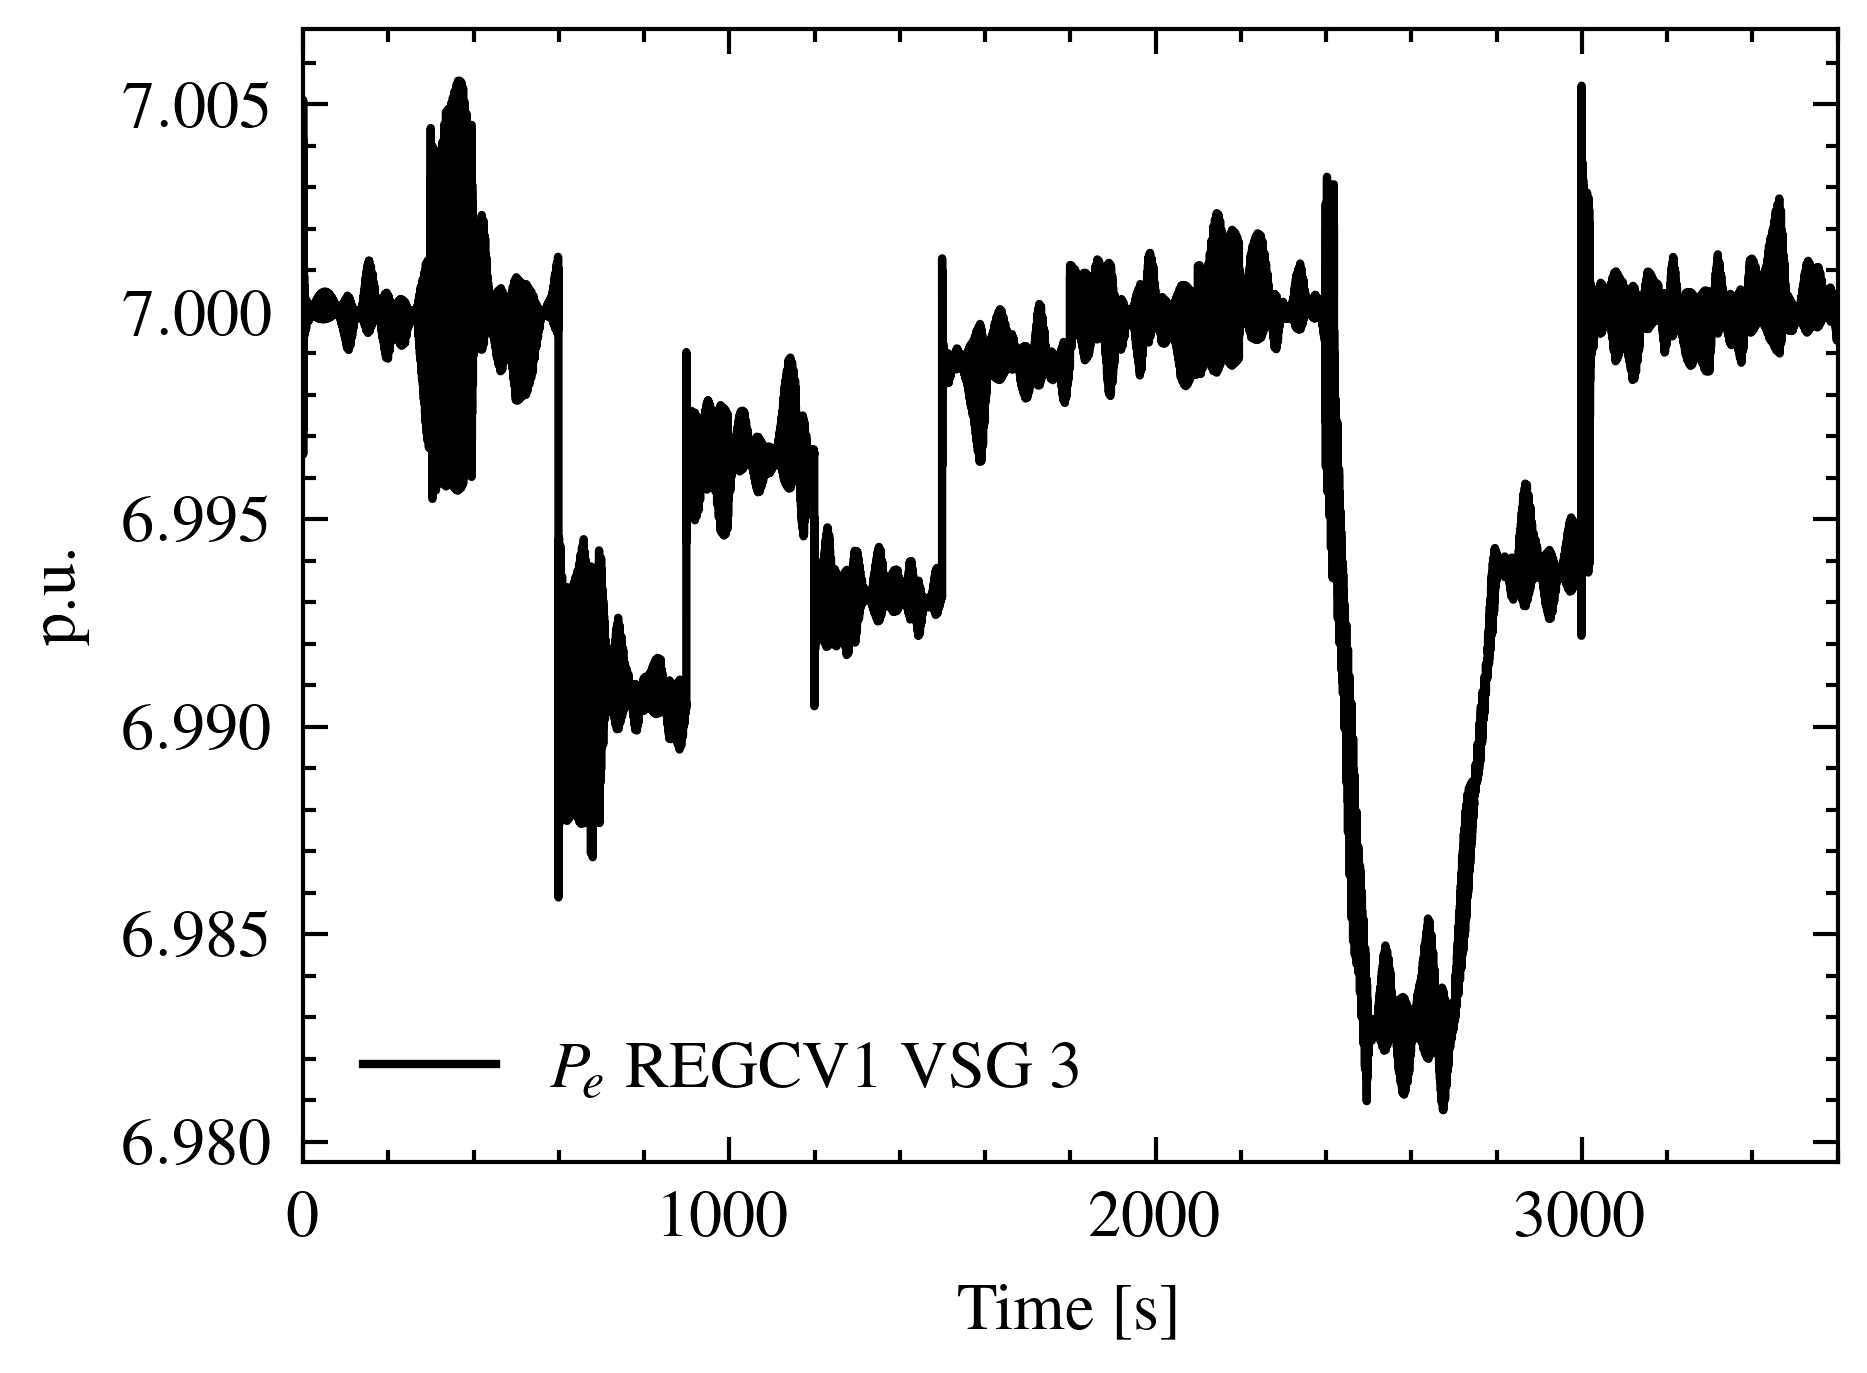

In [34]:
ssa.TDS.plt.plot(
                    ssa.REGCV1.Pe,
                    linestyles=['-'], 
                    a = (2),
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    ylabel='p.u.',
                )

(<Figure size 1980x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='p.u.'>)

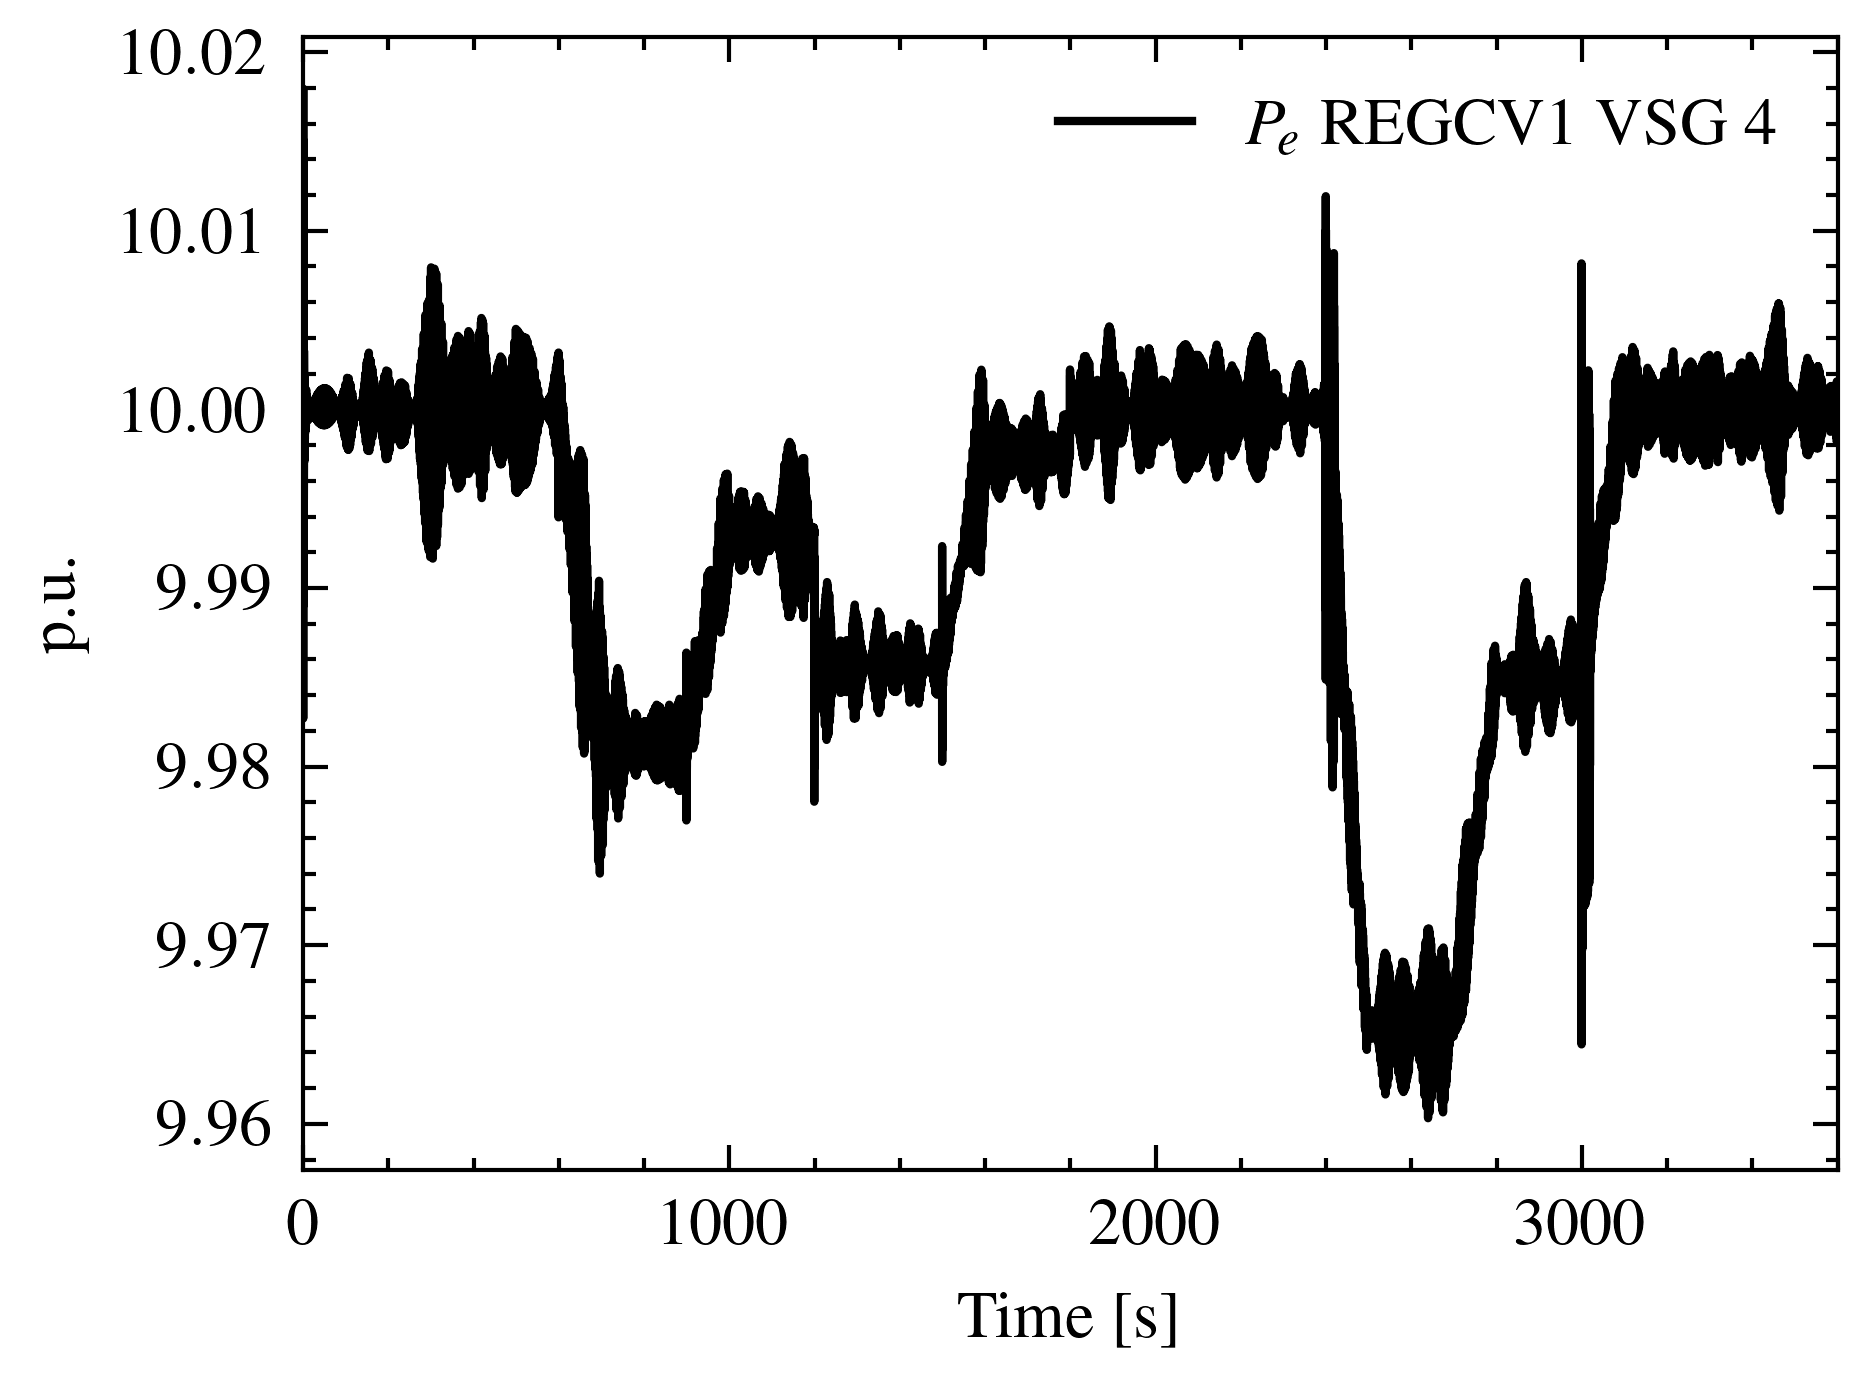

In [35]:
ssa.TDS.plt.plot(
                    ssa.REGCV1.Pe,
                    linestyles=['-'], 
                    a = (3),
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    ylabel='p.u.',
                )